# BART Webinar: A deep dive into non-Cartesian reconstruction with BART

This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with non-Cartesian data using BART.


## Outline
1. Bart Setup
2. The nuFFT in `bart`
3. Non-Cartesian Parallel Imaging
4. Performance
5. A small exercise

**Author**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) [H. Christian M. Holme](mailto:Holme@tugraz.at)

**Presenter**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) [H. Christian M. Holme](mailto:Holme@tugraz.at)

**Institution**: Institute of Biomedical Imaging, Graz University of Technology, Austria

**Moderator**: Jon Tamir, UT Austin



## 1 Setup BART

This notebook is designed to run on a local system and on Google Colab. It uses the python kernel, however, almost all commands use the `%%bash` cell magic to be executed in a `bash` subshell.

### 1.1 Google Colab

To run BART on Google Colab, this notebook automatically installs dependencies and sets up the GPUs if the environment variable `COLAB=1`is set. If you run this notebook on your local system, you might not want this setup. Please set `COLAB=0` in this case. For a detailed explanation, see the [How to Run BART on Google Colaboratory](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

In [3]:
%env COLAB=1

env: COLAB=1


Not all GPUs on Google Colab support CUDA 11, we downgrade CUDA if necessary:

In [ ]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Why Google?! As of May 13 cuda installed in colab (12.5) is incompatible with the driver (12.4)
# We install cuda 12.4 and link it here but it takes time!
apt install cuda-12-4

cd /usr/local
rm cuda
ln -s cuda-12.4 cuda

[ -d bart-webinars ] && rm -r bart-webinars
git clone https://github.com/mrirecon/bart-webinars.git > /dev/null


Branch 'webinar_07' set up to track remote branch 'webinar_07' from 'origin'.


Cloning into 'bart-webinars'...
Checking out files: 100% (133/133), done.
Switched to a new branch 'webinar_07'


In [30]:
import os
pwd=os.getcwd()
if os.environ["COLAB"] == "1":
    pwd=pwd+"/bart-webinars/webinar7/"

%cd $pwd

/content/bart-webinars/webinar7


### 1.2 Install libraries

We install dependencies for BART. Make sure that you have installed the requirements if you run locally:

In [ ]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Install BARTs dependencies
apt-get install -y make gcc-12 g++-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev time &> /dev/null

### 1.3 Clone and Compile BART

We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [ ]:
%%bash

# Clone Bart
[ -d bart ] && rm -r bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart

# Define compile options
COMPILE_SPECS=" CC=gcc-12
		PARALLEL=1
                PARALLEL_NJOBS=16
                CUDA=1
                "

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local


if [ $COLAB -eq "1" ]
then
    # set path to cuda for Colab
    echo "CUDA_BASE=/usr/local/cuda" >> Makefiles/Makefile.local
    echo "CUDA_LIB=lib64" >> Makefiles/Makefile.local
fi

make &> /dev/null

### 1.4 Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [7]:
import os
import sys

os.environ['TOOLBOX_PATH']=os.getcwd()+"/bart/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [8]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart//bart
# BART version: 
v0.8.00-158-g4935428


In [ ]:
%matplotlib inline

def plot(files, names=None, title=None, figsize=16):
	import numpy as np
	from matplotlib import pyplot as plt
	import cfl

	fig, axs = plt.subplots(1, len(files), squeeze=False, constrained_layout=True, figsize=(figsize, figsize / len(files)))

	for i, f in enumerate(files):
		dat = np.abs(cfl.readcfl(f)).squeeze()
		axs[0][i].imshow(dat,cmap = "gray")
		axs[0][i].set_title(f)

	plt.show()

def plot_phase(files, names=None, title=None, figsize=16):
	import numpy as np
	from matplotlib import pyplot as plt
	import cfl

	fig, axs = plt.subplots(1, len(files), squeeze=False, constrained_layout=True, figsize=(figsize, figsize / len(files)))

	ims = []
	for i, f in enumerate(files):
		dat = np.angle(cfl.readcfl(f)).squeeze()
		ims.append(axs[0][i].imshow(dat,cmap = "twilight_shifted", interpolation='nearest'))
		axs[0][i].set_title(f)
		ims[-1].set_clim((-np.pi, np.pi))
	plt.colorbar(ims[-1])

	plt.show()

## 2 The nuFFT in BART

### Definition of the nuDFT

$$
\begin{aligned}
\hat{f}(c_m)=\hat{f}_m 
&= \frac{1}{\sqrt{N}}\sum_{|c_n| \le \frac{N}{2}}\exp\left(\frac{-2\pi i}{N}\left(n-\frac{N}{2}\right)c_m\right)f_n
\end{aligned}
$$

* $f_n$ values on the Cartesian grid (with center N/2)
* $c_m$ coordinates of the non-Cartesian sample points
* $\hat{f}_m$ k-Space data at k-Space coordinate $c_m$

For Cartesian trajectories, this definition is consistent with the centered unitary FFT. As the grid spacing of $f_n$ is measured in units $\frac{\text{FoV}}{N}$, the k-Space coordinates are measured in units $\frac{1}{\text{FoV}}$. This convention has some implications concerning the effect of scaling the trajectory or choosing the grid size, discussed in 2.5.

**Warning**: The definition varies for different toolboxes by scaling of the data and/or trajectory. 



### 2.1 Trajectories

The `traj` tool can be used to generate trajectories in BART.
The first three dimensions of the generated trajectories contain

0. 3D-Coordinates (x, y, z), for 2D the z-coordinate is always 0
1. Readout
2. Phase-encoding

The splitting between readout and phase-encoding is arbitrary.

In [10]:
%%bash

bart traj trj_car
bart show -m trj_car

Type: complex float
Dimensions: 16
AoD:	3	128	128	1	1	1	1	1	1	1	1	1	1	1	1	1


For visualization, we generate a smaller trajectory with $N=32$. Radial trajectories are generated by `-r` option.
Other options can be used to modify the trajectory, i.e.

* **-D**: Double angle
* **-o os**: Oversampling with factor os
* **-G**: Golden angle


In [11]:
%%bash

bart traj        -x 16 -y 16 trj_car_vis
bart traj -r     -x 16 -y 11 trj_rad_vis_180
bart traj -r -D  -x 16 -y 11 trj_rad_vis_360
bart traj -r -o2 -x 16 -y 11 trj_rad_vis_os

Since we mainly work with radial trajectories, the trajectory tool mainly creates radial trajectories.
However, you can generate your own trajectory file following the conventions described above. In the following cell, we use Python to generate a spiral trajectory:

In [ ]:
import cfl
import numpy as np


def _spiral(kmax=64, turns=5, offset=0):

	theta=np.linspace(0 , 2 * np.pi, 2 * kmax * turns)

	x=kmax * theta / (2 * np.pi) * np.sin(turns * theta + offset)
	y=kmax * theta / (2 * np.pi) * np.cos(turns * theta + offset)
	z=np.zeros_like(y)

	return np.stack([x, y, z], axis = 0) #stack coordinates in dimension 0

def spiral(out, kmax=64, turns=5, interleaves=1):

	spirals=[]
	for i in range(interleaves):
		spirals.append(_spiral(kmax=kmax, turns=turns, offset= 2 * np.pi * i / interleaves))

	cfl.writecfl(out, np.stack(spirals, axis=2)) #stack interleaves in dimension 2

spiral("trj_spr_vis", kmax=8, interleaves=3, turns=5)
spiral("trj_spr", interleaves=4, turns=32)

And we visualize all trajectories:

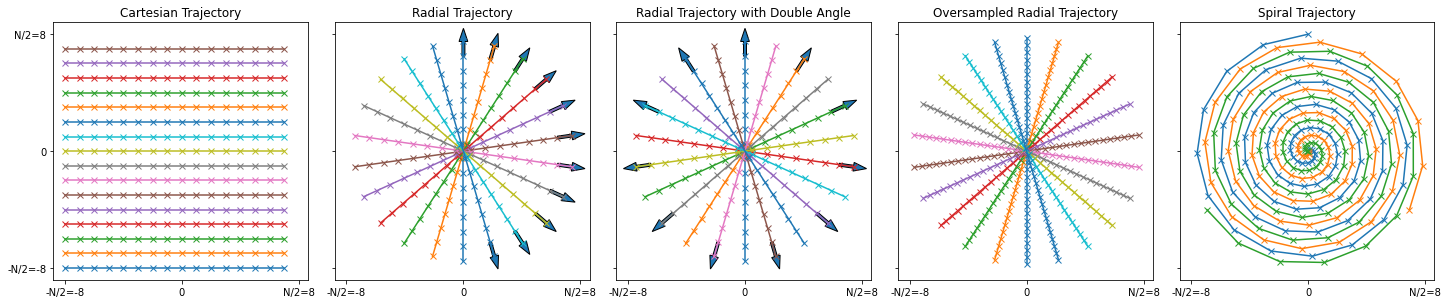

In [14]:
from matplotlib import pyplot as plt
import cfl

car = cfl.readcfl("trj_car_vis").real
rad_180 = cfl.readcfl("trj_rad_vis_180").real
rad_360 = cfl.readcfl("trj_rad_vis_360").real
rad_os = cfl.readcfl("trj_rad_vis_os").real
spr = cfl.readcfl("trj_spr_vis").real

fig, axs = plt.subplots(1, 5, squeeze=False, sharex=True, sharey=True, constrained_layout=True, figsize=(20,4))

axs[0][0].plot(car[0], car[1], marker="x")

axs[0][1].plot(rad_180[0], rad_180[1], marker="x")
for i in range(rad_180[0].shape[1]):
	axs[0][1].arrow(rad_180[0][-2][i], rad_180[1][-2][i], rad_180[0][-1][i]-rad_180[0][-2][i], rad_180[1][-1][i]-rad_180[1][-2][i], width=0.2)

axs[0][2].plot(rad_360[0], rad_360[1], marker="x")
for i in range(rad_360[0].shape[1]):
	axs[0][2].arrow(rad_360[0][-2][i], rad_360[1][-2][i], rad_360[0][-1][i]-rad_360[0][-2][i], rad_360[1][-1][i]-rad_360[1][-2][i], width=0.2)

axs[0][3].plot(rad_os[0], rad_os[1], marker="x")
axs[0][4].plot(spr[0], spr[1], marker="x")

for ax in axs.flatten():
	ax.set_aspect(1)

axs[0][0].set_xticks([-8,0,8])
axs[0][0].set_yticks([-8,0,8])

axs[0][0].set_xticklabels(["-N/2=-8","0","N/2=8"])
axs[0][0].set_yticklabels(["-N/2=-8","0","N/2=8"])

axs[0][0].set_title("Cartesian Trajectory")
axs[0][1].set_title("Radial Trajectory")
axs[0][2].set_title("Radial Trajectory with Double Angle")
axs[0][3].set_title("Oversampled Radial Trajectory")
axs[0][4].set_title("Spiral Trajectory")

plt.show()


### 2.2 Non-Cartesian k-Space

The corresponding k-Space has a singleton dimension in the first dimension, its dimensions are:

0. 1
1. Readout
2. Phase-encoding

We generate the non-Cartesian k-space of a Shepp-Logan phantom:

In [15]:
%%bash

bart traj    -x 128 -y 128 trj_car
bart traj -r -x 128 -y 196 trj_rad

bart phantom -k -ttrj_car ksp_car
bart phantom -k -ttrj_rad ksp_rad
bart phantom -k -ttrj_spr ksp_spr

bart show -m ksp_car
bart show -m ksp_rad
bart show -m ksp_spr

Type: complex float
Dimensions: 16
AoD:	1	128	128	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	1	128	196	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	1	4096	4	1	1	1	1	1	1	1	1	1	1	1	1	1


### 2.3 The nuFFT Tool

To apply the nuFFT, the `bart nufft` command is used, it has three modes, i.e.

* forward: as in the definition above (k-space to image space)
	* `bart nufft    <trj> <img> <ksp>`
	* $\text{<ksp>} = \mathcal{PF}\text{<img>}$
* adjoint: the adjoint of the forward mode
	* `bart nufft -a <trj> <ksp> <img>`
	* $\text{<img>} = (\mathcal{PF})^H\text{<ksp>}$
* inverse: iterative solution of inverse problem
	* `bart nufft -i <trj> <ksp> <img>`
	* $\DeclareMathOperator*{\argmin}{arg\,min}\text{<img>} = \argmin_x \lVert \mathcal{PF}x - \text{<ksp>} \rVert_2^2 + \lambda \lVert x\rVert_2^2$

For the Cartesian case, the adjoint and the inverse coincide, and we can use the FFT instead of the nuFFT:

In [16]:
%%bash

bart nufft -a   trj_car ksp_car img_car
bart fft   -i 7         ksp_car img_fft

bart show -m img_car
bart show -m img_fft

Est. image size: 128x128x1
Done.
Type: complex float
Dimensions: 16
AoD:	128	128	1	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	1	128	128	1	1	1	1	1	1	1	1	1	1	1	1	1


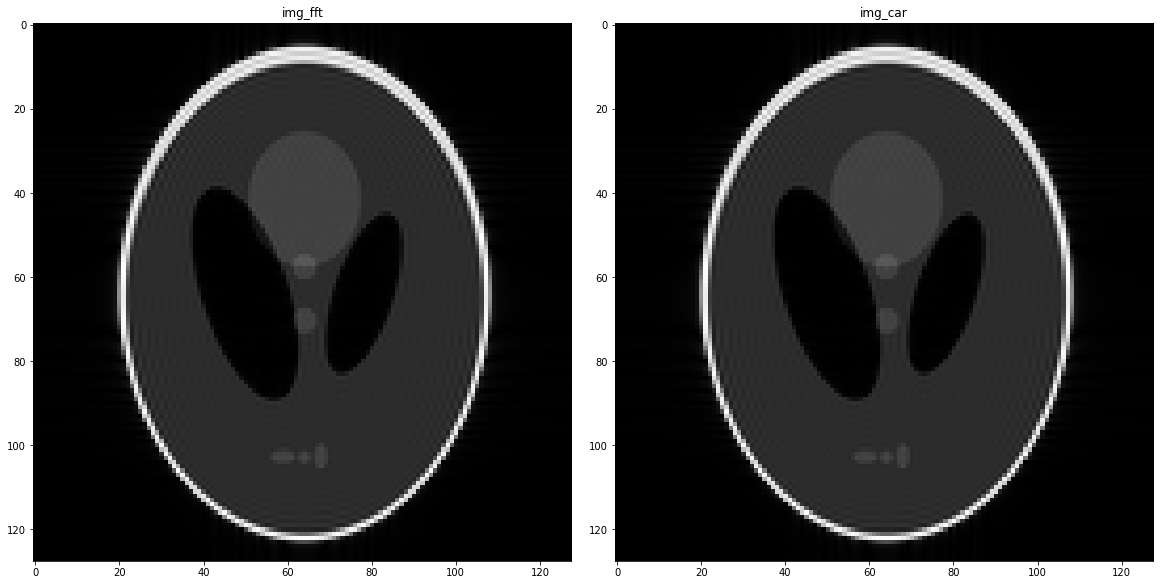

In [17]:
plot(["img_fft", "img_car"])


#### 2.3.1 Inverse vs. Density Compensation

For non-Cartesian trajectories, the adjoint and the inverse of the nuFFT do not coincide.
There are two possibilities to deal with this.

1. Approximate the inverse nuFFT by weighting the samples with the density compensation function $d(c_m)$
2. Compute the inverse iteratively by solving the inverse problem $\DeclareMathOperator*{\argmin}{arg\,min}\text{<img>} = \argmin_x \lVert \mathcal{PF}x - \text{<ksp>} \rVert_2^2 + \lambda \lVert x\rVert_2^2$



In [18]:
%%bash

bart nufft -a trj_rad ksp_rad img_rad

# Density compensation: |k| = \sqrt{k_x^2 + k_y^2 + k_z^2} = rss(k)
bart rss $(bart bitmask 0) trj_rad mag

bart fmac ksp_rad mag ksp_rad_density
bart nufft -a trj_rad ksp_rad_density img_rad_density

#Inverse nuFFT
bart nufft -i trj_rad ksp_rad img_rad_inverse

#Inverse nuFFT Spiral
bart nufft -i trj_spr ksp_spr img_spr_inverse

Est. image size: 128x128x1
Done.
Est. image size: 128x128x1
Done.
Est. image size: 128x128x1
Done.
Est. image size: 128x128x1
Done.


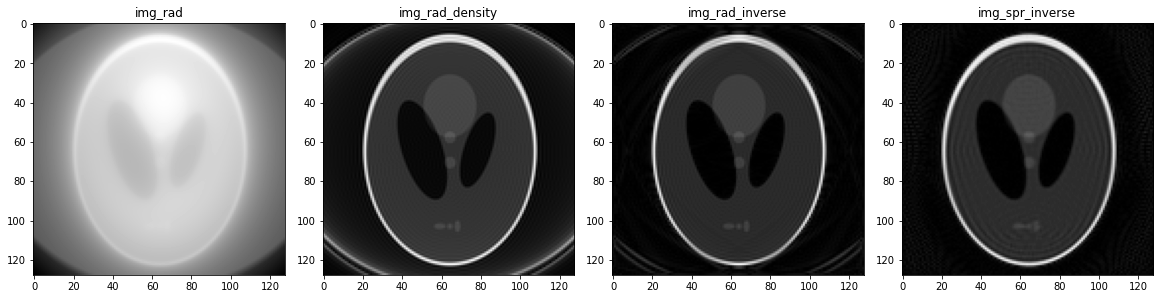

In [19]:
plot(["img_rad", "img_rad_density", "img_rad_inverse", "img_spr_inverse"])

### 2.5 Scaling, Oversampling, Image-Dimensions

As the trajectory is measured in units of $\frac{1}{\text{FoV}}$, the FoV can be changed by scaling the trajectory.
The matrix size is estimated from the trajectory but can also be specified, however, it does not influence the FoV.


In [ ]:
%%bash

#normal FoV
bart nufft -a             trj_rad ksp_rad_density normal

#denser sampling of the same FoV
bart nufft -a -d256:256:1 trj_rad ksp_rad_density dims

#rescaled FoV
bart scale 2 trj_rad trj_rad_scl
bart nufft -a -d256:256:1 trj_rad_scl ksp_rad_density scaled

Est. image size: 128x128x1
Done.
Done.
Done.


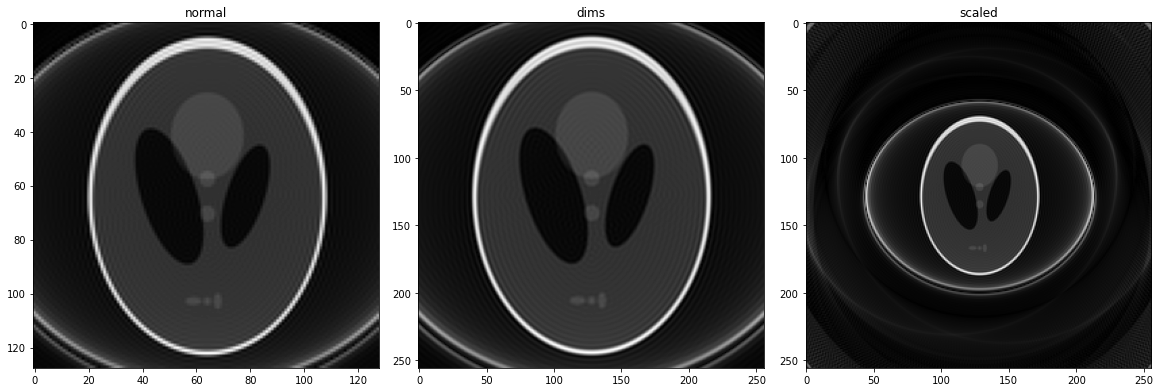

In [21]:
plot(["normal", "dims", "scaled"])

### 2.6 FoV Shift and Rotation

The Fourier transform shows some properties, we can exploit to shift and rotate the FoV, i.e.
$$
\begin{aligned}
\tilde{f}(\vec{x}) &= f(\vec{x}-\vec{a}) &&\Rightarrow& \hat{\tilde{f}}(\vec{k}) &= \exp\left(-2\pi \vec{k} \cdot \vec{a}\right)\hat{f}(\vec{k})\\
\tilde{f}(\vec{x}) &= f(R_{\theta}\vec{x}) &&\Rightarrow& \hat{\tilde{f}}(\vec{k}) &= \hat{f}(R_{\theta}\vec{k})\\
\end{aligned}
$$
To rotate the (radial) trajectory, we provide the **-R** option in the trajectory tool.
To shift the FoV, we provide the **fovshift** tool.

In [22]:
%%bash

bart traj -x128 -y256 -r -o4 trj_os_tmp
bart phantom -k -t trj_os_tmp ksp_os

bart traj -x256 -y256 -r -o2 trj
bart nufft -i trj ksp_os img

# Create rotated trajectory (-R=45°)
bart traj -R45 -x256 -y256 -r -o2 trj
bart nufft -i trj ksp_os img_rot


bart traj -x256 -y256 -r -o2 trj

#shift kspace
bart fovshift -t trj -s-0.25:-0.25:0 ksp_os ksp_shift

bart nufft -i trj ksp_shift img_shift

Est. image size: 256x256x1
Done.
Est. image size: 256x256x1
Done.
Est. image size: 256x256x1
Done.


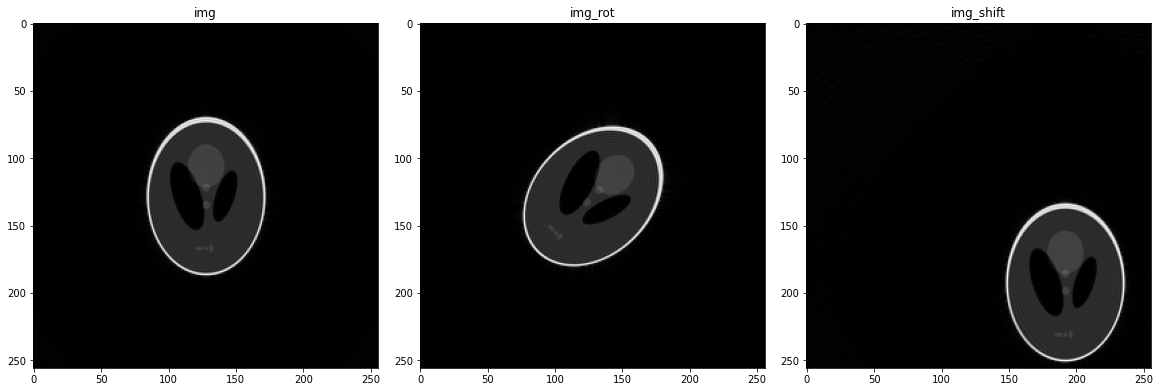

In [23]:
plot(["img", "img_rot", "img_shift"])

## 3 Non-Cartesian Parallel Imaging (and Compressed Sensing)
### 3.0 A short excursion to 3D imaging

Before we get too far into non-Cartesian reconstruction using `bart`, let us talk about problem quite a number of people using 3D noncart reconstructions run into: In the case of noncart 3D-Data, the inverse nuFFT is very badly conditioned and the least squares approach might not (ever) converge.

In the previous sections we heard how an adjoint nuFFT with density compensation (or a Ram-Lak or ramp filter) can (in some cases) approximate the inverse of the nuFFT. Similarly, weighting our reconstruction with such a filter can improve conditioning and lead to faster reconstruction. However, we are not solving the original problem anymore: This weighting changes the problem we solve and will, in most cases, lead to worse behavior with respect to noise.

But let's look at an example (in 2D, for shorter reconstruction times). We will create a radial trajectory with a bit of undersampling (127 spokes for 256x256 FOV). Then, we try non-Cartesian reconstruction using our Parallel Imaging and Compressed Sensing tool, `pics`. As we do not want to look at parallel imaging here, we simply use 1's as our single coil sensitivity profile:

GPU reconstruction
[  1 256 127   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 5.887995


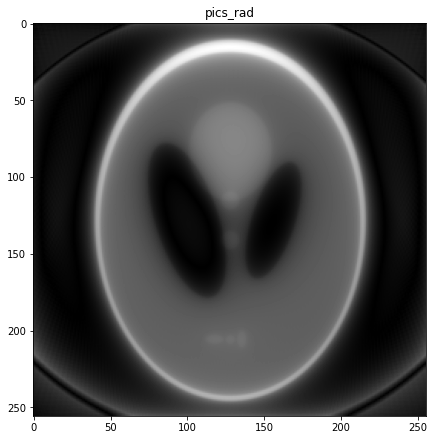

In [24]:
# Create 2D radial trajectory
!bart traj -r -D -x 256 -y 127 tr
# Simulate corresponding phantom data in k-space
!bart phantom -ttr -k ksp_rad

# 256 by 256 1's as "sensitivities"
!bart ones 2 256 256 sens1

# non-Cartesian pics reconstruction using just 3 iterations:
!bart pics -g -i 3 -ttr ksp_rad sens1 pics_rad
plot(["pics_rad"], figsize=6)

As we can see, the image is quite blurry. But with 3 steps, that is all we can expect.

So now we will use a ram-lak filter as a weighting matrix in `pics`. With that, we calculate the filter using `rss` as before. But since `pics` uses a normal operator to solve the least-squares problem, we need the square root of our filter here:

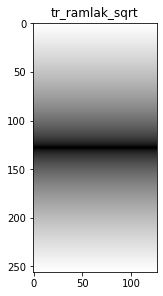

GPU reconstruction
[  1 256 127   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 2.658690


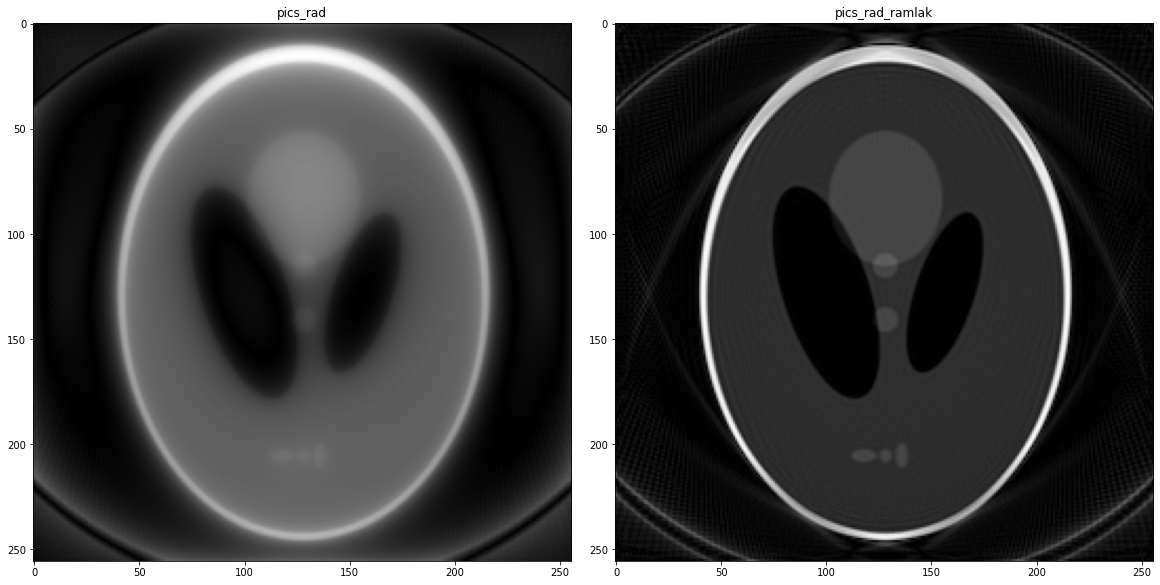

In [25]:
!bart rss 1 tr tr_ramlak
!bart spow 0.5 tr_ramlak tr_ramlak_sqrt

plot(['tr_ramlak_sqrt'], figsize=4)

!bart pics -g -i 3 -p tr_ramlak_sqrt -t tr ksp_rad sens1 pics_rad_ramlak


plot(["pics_rad", "pics_rad_ramlak"])

So with the weighting, 3 steps are enough for a much less blurry reconstruction.

And if we use a more reasonable number of step (say, 30), we can get good images even without weighting:

GPU reconstruction
[  1 256 127   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 2.921474
GPU reconstruction
[  1 256 127   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 2.482220


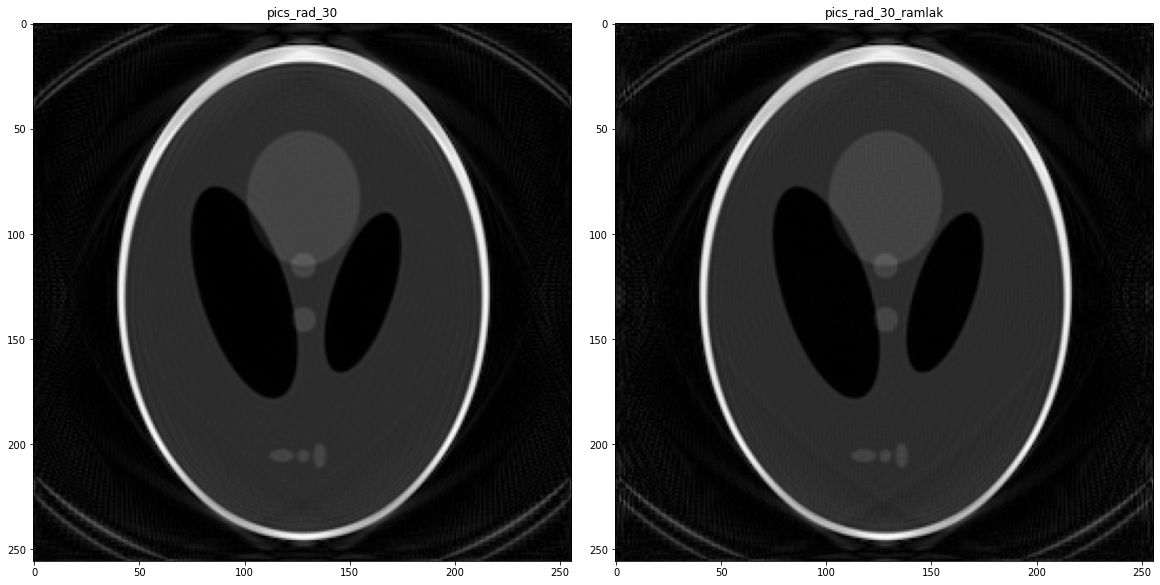

In [26]:
!bart pics -g -i 30                  -ttr ksp_rad sens1 pics_rad_30
!bart pics -g -i 30 -ptr_ramlak_sqrt -ttr ksp_rad sens1 pics_rad_30_ramlak


plot(["pics_rad_30", "pics_rad_30_ramlak"])

But: if we look closely, we can already see problems creeping in because of our use the Ram-Lak filter as weighting.

### 3.1 Coil Sensitivity Profiles using ESPIRiT


For parallel imaging, we need some way to get coil sensitivity profiles. While it is possible to measure coil profiles using a seperate Cartesian scan, for example, a far more pleasant way is to determine coil sensitivity profiles using the non-Cartesian data itself.

A common method for coil sensitivity is ESPIRiT, implemented as the `ecalib` tool in `bart`.

Here, we use a spiral dataset that was acquired as part of the first ISMRM Reproducibility Challenge. This is almost in `bart` format already (so even datasets "in the wild" sometimes use this format!).

After extracting the trajectory from the the .hdf5 file (https://zenodo.org/record/3975887 `rawdata_spiral_ETH.h5`), we find that it has the following dimensions:


In [31]:
%%bash
bart show -m spiral_ETH_cfl/trj_spiral_orig

Type: complex float
Dimensions: 16
AoD:	2	27121	3	1	1	1	1	1	1	1	1	1	1	1	1	1


It is a spiral dataset with quite long spirals (>27.000 samples) and 3 interleaves.


But in `bart`, the first dimension of the trajectory has to be 3 (even for 2D imaging). Therefore, we extend dimension 0 to a size of 3 with zeros:

In [32]:
%%bash
bart resize 0 3 spiral_ETH_cfl/trj_spiral_orig spiral_ETH_cfl/trj_spiral
bart show -m spiral_ETH_cfl/trj_spiral

Type: complex float
Dimensions: 16
AoD:	3	27121	3	1	1	1	1	1	1	1	1	1	1	1	1	1


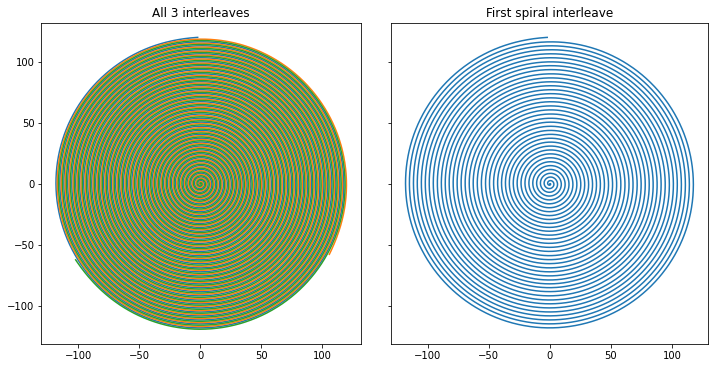

In [34]:
import matplotlib.pyplot as plt
import cfl

spir = cfl.readcfl("spiral_ETH_cfl/trj_spiral").real

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5), squeeze=True, sharey=True, constrained_layout=True)

ax1.plot(spir[0], spir[1])
ax1.set_aspect(1)
ax1.set_title("All 3 interleaves")

ax2.plot(spir[0,:,0], spir[1,:,0])
ax2.set_aspect(1)
ax2.set_title("First spiral interleave")

plt.show()


From the metadata, we know that the FOV was 220x220 mm with a pixel size of 1x1 mm. Therefore, our matrix size should be 220x200. In order to calculate coil profiles using ESPIRiT, we need data on a Cartesian grid. Therefore, we use the inverse `nufft` to grid our data, followed by an `fft` to get data in k-space:

In [35]:
%%bash

bart nufft -x 220:220:1 -i -g spiral_ETH_cfl/trj_spiral spiral_ETH_cfl/raw_spiral nufft_spiral
bart fft -u 7 nufft_spiral ksp_spiral

bart slice 3  0 ksp_spiral ksp_spiral_coil00
bart slice 3  5 ksp_spiral ksp_spiral_coil05
bart slice 3 12 ksp_spiral ksp_spiral_coil12

Done.


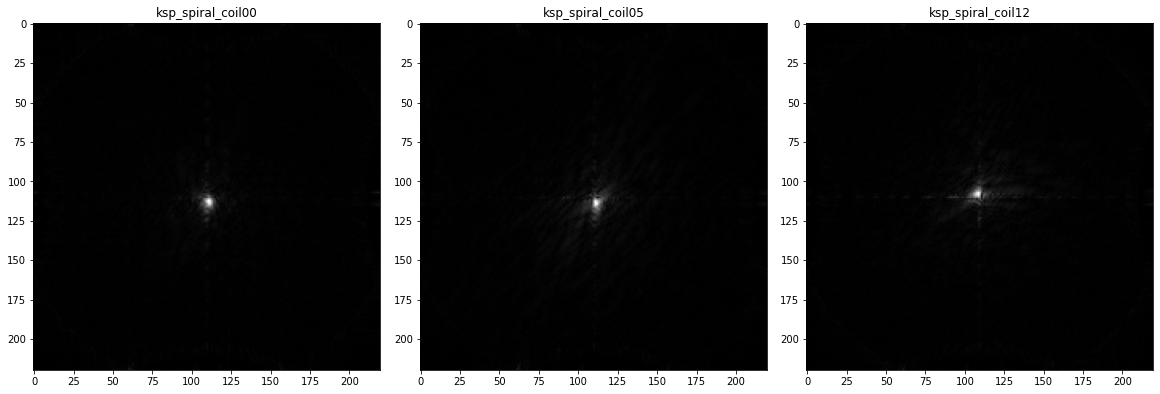

In [36]:
plot(["ksp_spiral_coil00", "ksp_spiral_coil05", "ksp_spiral_coil12"])
!rm ksp_spiral_coil{00,05,12}.{cfl,hdr}

So let's see what ecalib needs to do its magic:

In [37]:
!bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h               help


In [38]:
%%bash

bart ecalib -m 1 ksp_spiral ecal_spiral

bart slice 3 0 ecal_spiral ecal_spiral_coil00
bart slice 3 5 ecal_spiral ecal_spiral_coil05
bart slice 3 12 ecal_spiral ecal_spiral_coil12

Done.


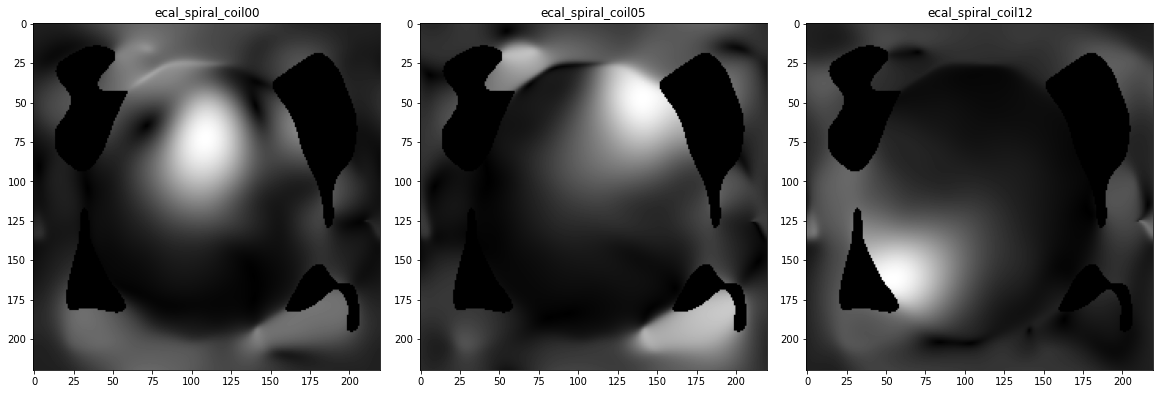

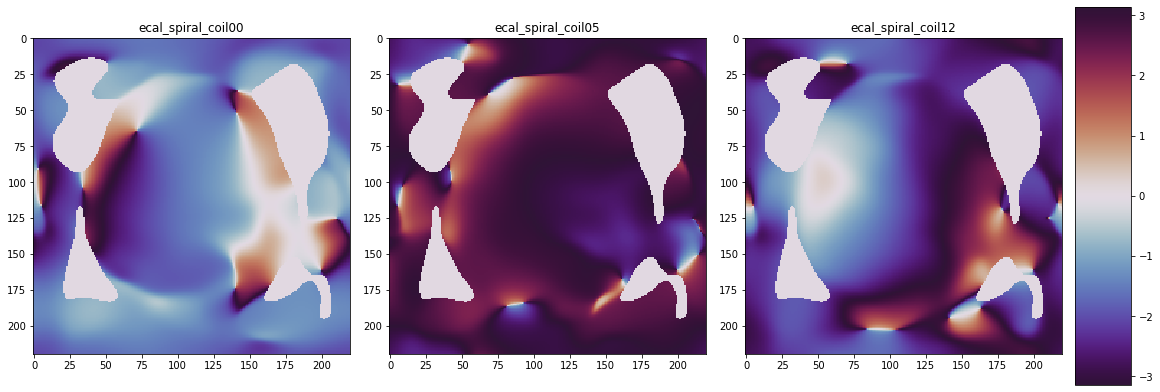

In [39]:
plot(["ecal_spiral_coil00", "ecal_spiral_coil05", "ecal_spiral_coil12"])
plot_phase(["ecal_spiral_coil00", "ecal_spiral_coil05", "ecal_spiral_coil12"])

Next, we will use `pics` to reconstruct our non-Cartesian data. Not that we can just pass our trajectory to pics, we do not need to grid our data first.

In [40]:
%%bash
bart pics -h

Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [--gpu-gridding] [-G d] [-p <file>] [-I] [-b d] [-e] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-m] [-w f] [-S] [-L d] [-K] [-B <file>] [-P f] [-a] [-M] [-U,--lowmem] [--no-toeplitz] [--psf_export <file>] [--psf_import <file>] [--wavelet <string>] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.


-l 1/-l2              toggle l1-wavelet or l2 regularization.
-r lambda            regularization parameter
-R <T>:A:B:C         generalized regularization options (-Rh for help)
-c                   real-value constraint
-s step              iteration stepsize
-i iter              max. number of iterations
-t file              k-space trajectory
-n                   disable random wavelet cycle spinning
-N                   do fully overlapping LLR blocks
-g                   use GPU
--gpu-gridding       use GPU for gridding
-G gpun              use GPU device gpun
-p file

Here, we specifically try without Toeplitz first, and then with Toeplitz in the next step.

Note: In contrast to the `nufft` above, we do not need to specify the image size of 220x220 in our pics command. This is because we give pics coil sensitivity profiles in image space, which already define the matrix size. However, it is important that the coils actually are of the correct size for the given trajectory, otherwise reconstruction will fail (as image and coils and not compatible).

[  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
[220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 16754.009766  (max = 22542.732422/p90 = 16754.009766/median = 5994.595215)
Inverse scaling of the data: 16754.009766
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
	 cg:  30
Total Time: 38.811501


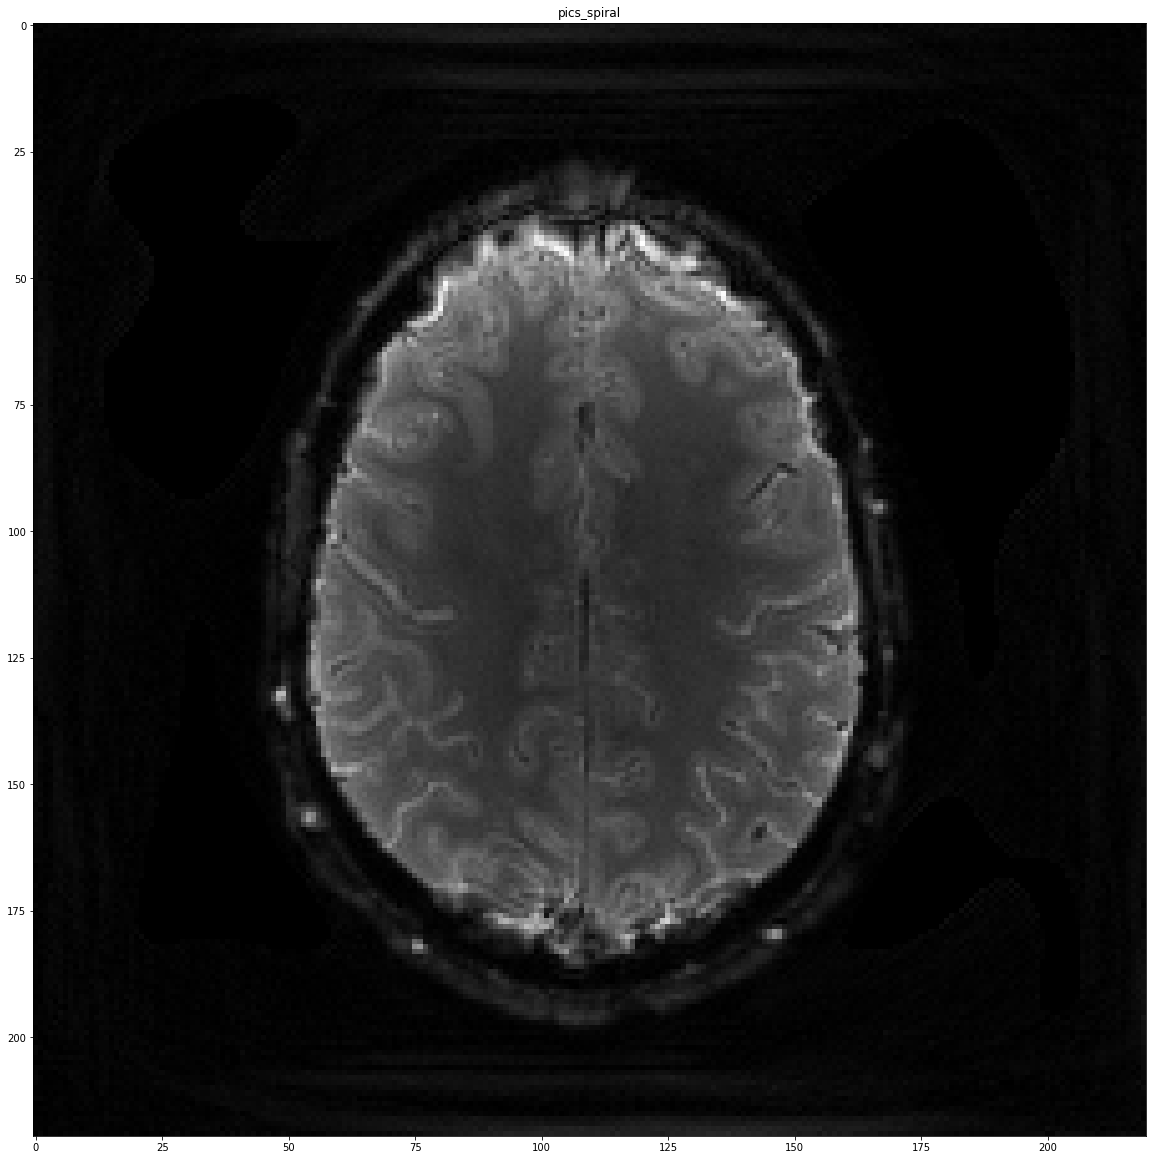

In [41]:
!bart pics -d4 -i30 --no-toeplitz -r1e-4 \
            -t spiral_ETH_cfl/trj_spiral \
            spiral_ETH_cfl/raw_spiral ecal_spiral pics_spiral

plot(["pics_spiral"])

In [42]:
!bart pics -d4 -i30                 -r1e-4 \
            -t spiral_ETH_cfl/trj_spiral \
            spiral_ETH_cfl/raw_spiral ecal_spiral pics_spiral_Toep

!echo "NRMSE: "
!DEBUG_LEVEL=0 bart nrmse -s pics_spiral_Toep pics_spiral


[  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
[220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [220 220   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
Scaling: 16754.011719  (max = 22542.732422/p90 = 16754.011719/median = 5994.594727)
Inverse scaling of the data: 16754.011719
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
	 cg:  30
Total Time: 8.088848
NRMSE: 
0.021555


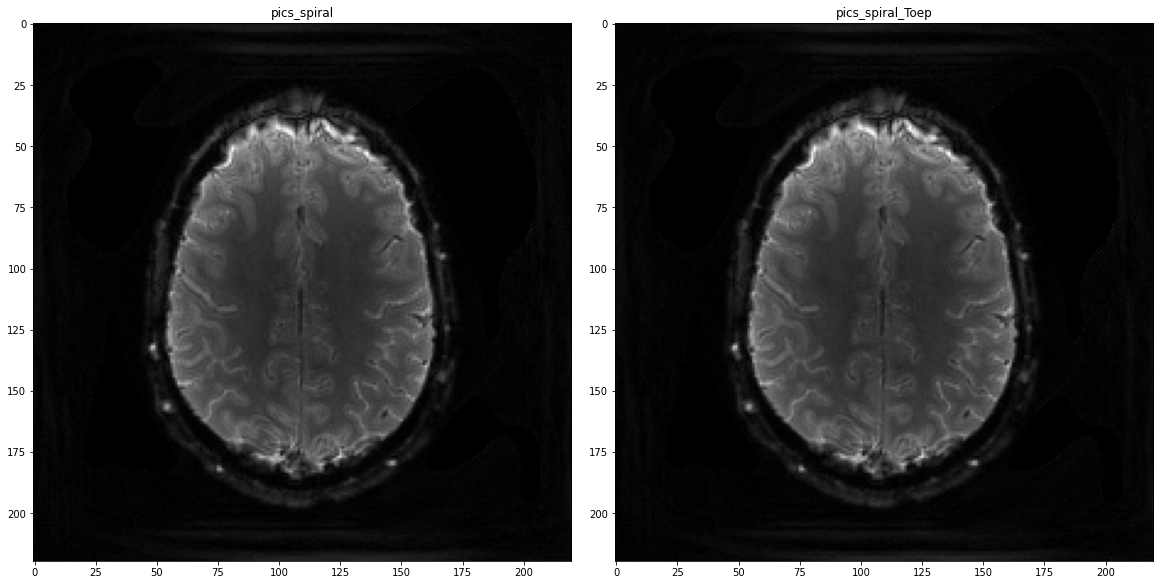

In [43]:
plot(["pics_spiral", "pics_spiral_Toep"])

As we can see (and as we expected), we get similar results with and without Toeplitz. However, with Toeplitz our reconstruction took less than half the time (but did use more memory!).

### 3.2 Non-linear inverse reconstruction (NLINV)

Instead of `pics`, which needs coil sensitivity profiles, we can also use NLINV to reconstruct and image and calculate coil profiles simultaneously. An advantage of this approach is that no calibration step is needed, and so no separate gridding step (as the gridding is done internally).

In [44]:
%%bash
bart nlinv -h

Usage: nlinv [-i d] [-d d] [-c] [-N] [-m d] [-U] [-f f] [-p <file>] [-t <file>] [-I <file>] [-g] [-S] [--lowmem] [-x d:d:d] <kspace> <output> [<sensitivities>] 

Jointly estimate image and sensitivities with nonlinear
inversion using {iter} iteration steps. Optionally outputs
the sensitivities.

-i iter     Number of Newton steps
-d level    Debug level
-c          Real-value constraint
-N          Do not normalize image with coil sensitivities
-m nmaps    Number of ENLIVE maps to use in reconstruction
-U          Do not combine ENLIVE maps in output
-f FOV      restrict FOV
-p file     pattern / transfer function
-t file     kspace trajectory
-I file     File for initialization
-g          use gpu
-S          Re-scale image after reconstruction
--lowmem    Use low-mem mode of the nuFFT
-x x:y:z    Explicitly specify image dimensions
-h          help


Similarly to the `nufft` (and in contrast to `pics`), we do need to specify the image size here. 

[220 220   1 ]
nufft kernel dims: [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [440 440   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 81363 (vs. 274963) + 193600
ksp : [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [440 440   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [440 440   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.000028
Step: 0, Res: 99.999990
	 cg:   1
Step: 1, Res: 97.158698
	 cg:   1
Step: 2, Res: 92.439528
	 cg:   1
Step: 3, Res: 88.122640
	 cg:   2
Step: 4, Res: 77.851459
	 cg:   4
Step: 5, Res: 71.530922
	 

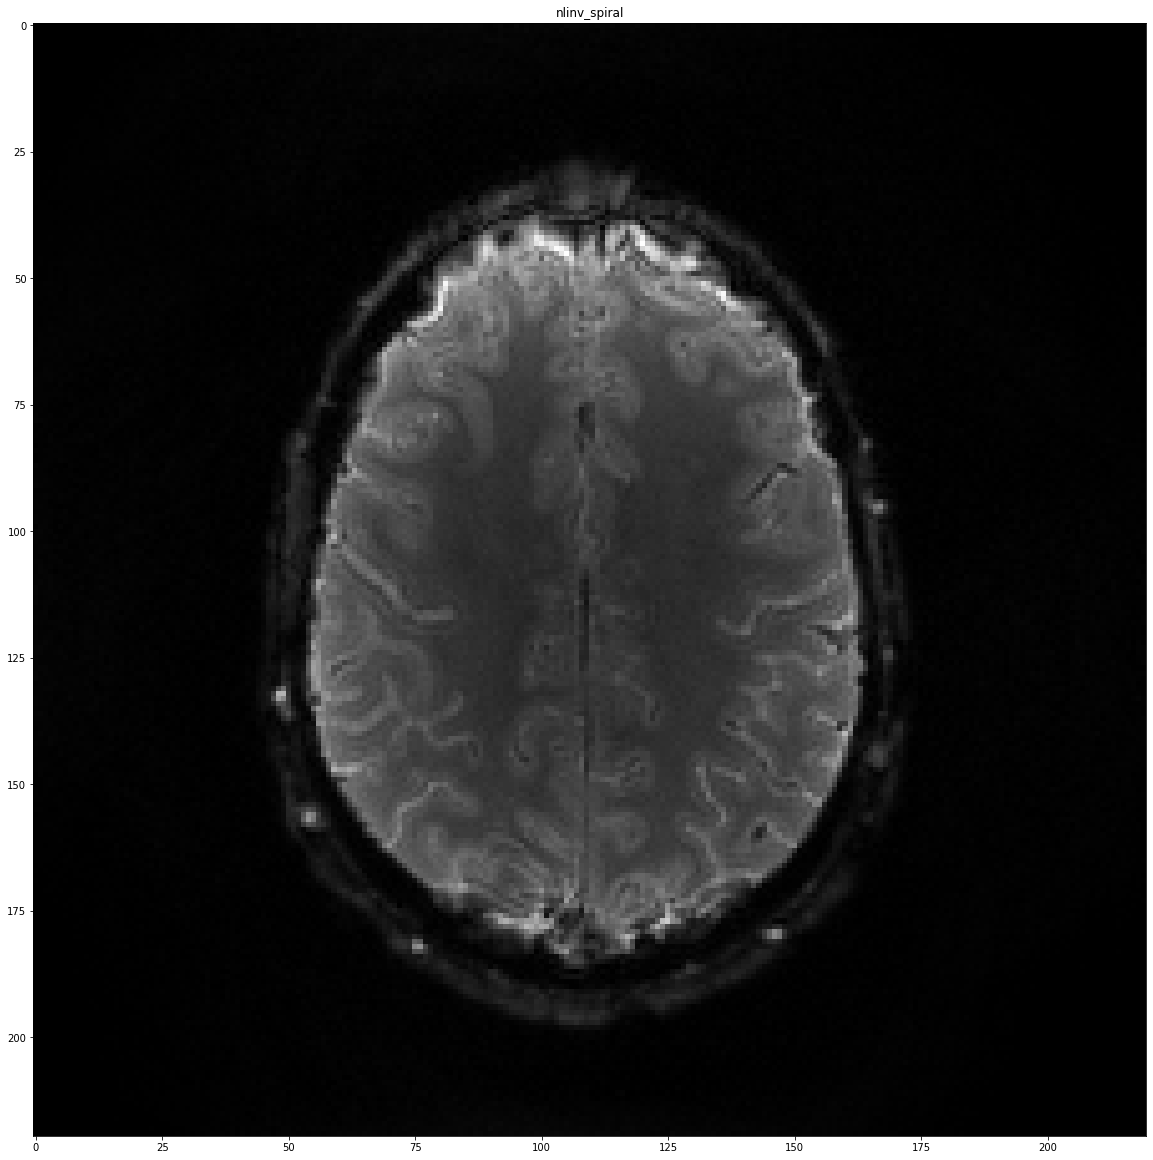

In [ ]:
!bart nlinv -S -d4 -i11 -g -x 220:220:1 -t spiral_ETH_cfl/trj_spiral spiral_ETH_cfl/raw_spiral \
        nlinv_spiral nlinv_sens_spiral


plot(["nlinv_spiral"])

This, too, works with any trajectory, the only requirement is that the data is in `bart`-format.



Occasionally, we might want to use a linear reconstruction such as `pics` (e.g. for easier incorporation of regularization), but want the ease (and robustness) of calculating coil profiles with `nlinv`. 

In that case, we can use the the coil profiles generated by `nlinv` together with pics. 

But there is one pitfall: `nlinv`, by default, oversamples the coil profiles by a factor of two, that means it's coil profiles are too large. See here:

In [46]:
%%bash
bart show -m nlinv_sens_spiral

Type: complex float
Dimensions: 16
AoD:	440	440	1	16	1	1	1	1	1	1	1	1	1	1	1	1


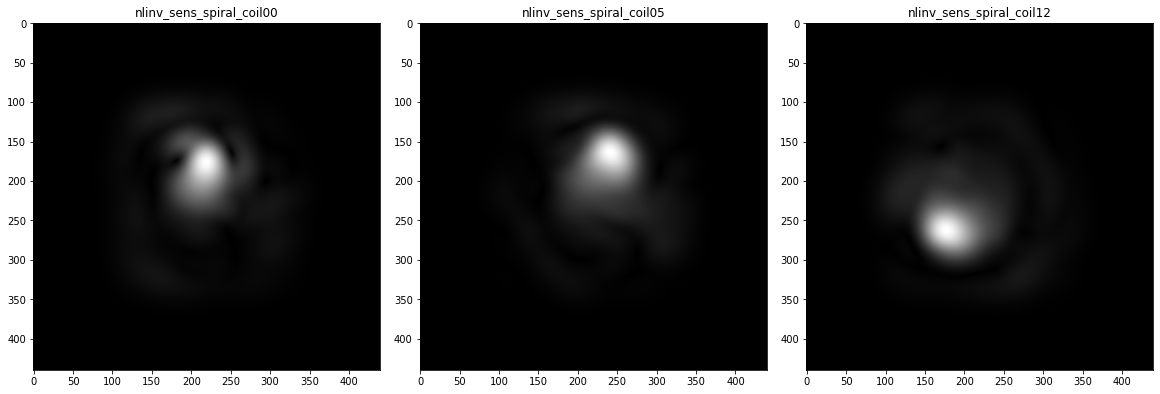

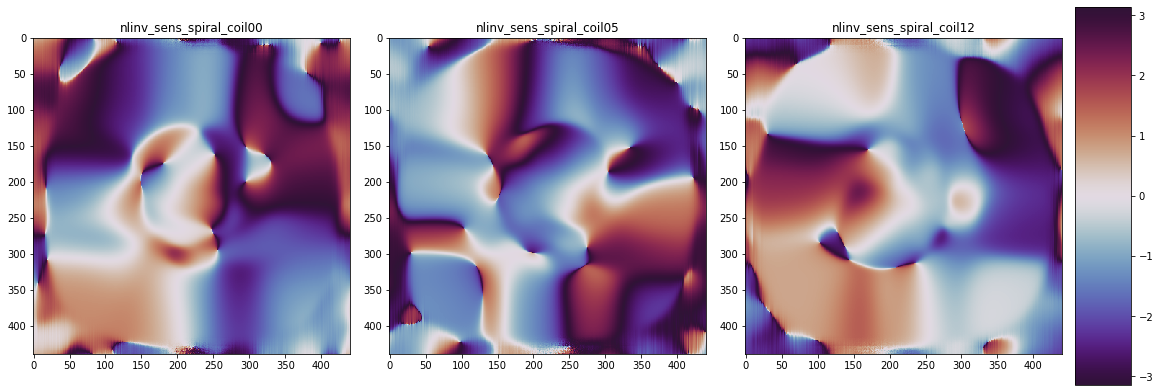

In [47]:
!bart slice 3 0 nlinv_sens_spiral nlinv_sens_spiral_coil00
!bart slice 3 5 nlinv_sens_spiral nlinv_sens_spiral_coil05
!bart slice 3 12 nlinv_sens_spiral nlinv_sens_spiral_coil12

plot(["nlinv_sens_spiral_coil00", "nlinv_sens_spiral_coil05", "nlinv_sens_spiral_coil12"])
plot_phase(["nlinv_sens_spiral_coil00", "nlinv_sens_spiral_coil05", "nlinv_sens_spiral_coil12"])

!rm nlinv_sens_spiral_coil{00,05,12}.{cfl,hdr}

So what we want is the inner 220x220 pixels of these coil profiles. For good measure, we also normalize them along the coil dimension:

In [48]:
%%bash
bart resize -c 0 220 1 220 nlinv_sens_spiral nlinv_sens_spiral_resized_not_normalized
bart normalize 8 nlinv_sens_spiral_resized_not_normalized nlinv_sens_spiral_resized

bart show -m nlinv_sens_spiral_resized

Type: complex float
Dimensions: 16
AoD:	220	220	1	16	1	1	1	1	1	1	1	1	1	1	1	1


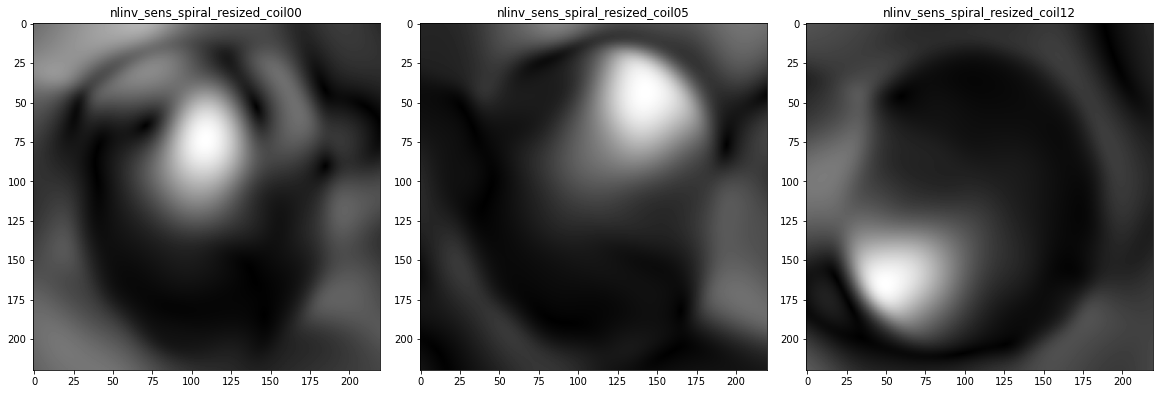

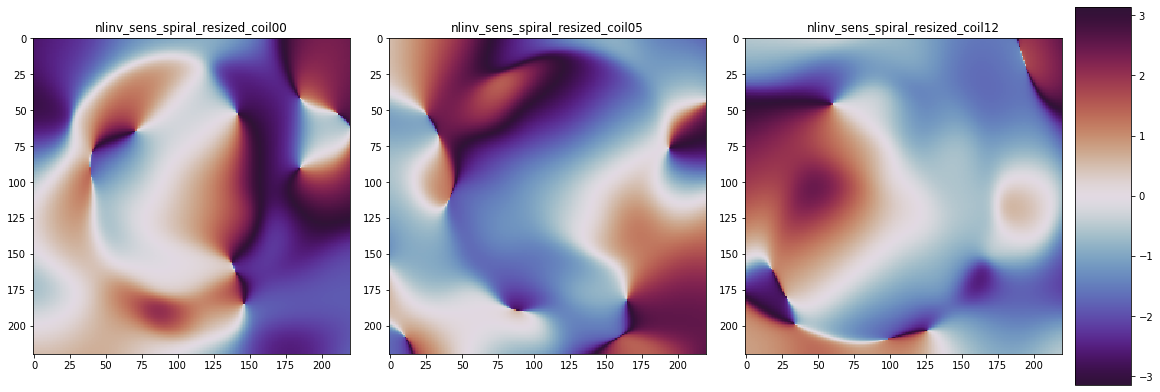

In [49]:
!bart slice 3 0 nlinv_sens_spiral_resized nlinv_sens_spiral_resized_coil00
!bart slice 3 5 nlinv_sens_spiral_resized nlinv_sens_spiral_resized_coil05
!bart slice 3 12 nlinv_sens_spiral_resized nlinv_sens_spiral_resized_coil12

plot(["nlinv_sens_spiral_resized_coil00", "nlinv_sens_spiral_resized_coil05", "nlinv_sens_spiral_resized_coil12"])
plot_phase(["nlinv_sens_spiral_resized_coil00", "nlinv_sens_spiral_resized_coil05", "nlinv_sens_spiral_resized_coil12"])

!rm nlinv_sens_spiral_resized_coil{00,05,12}.{cfl,hdr}

So these now have the correct dimensions, and we can direclty use them in `pics`:

GPU reconstruction
[  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
[220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.817106


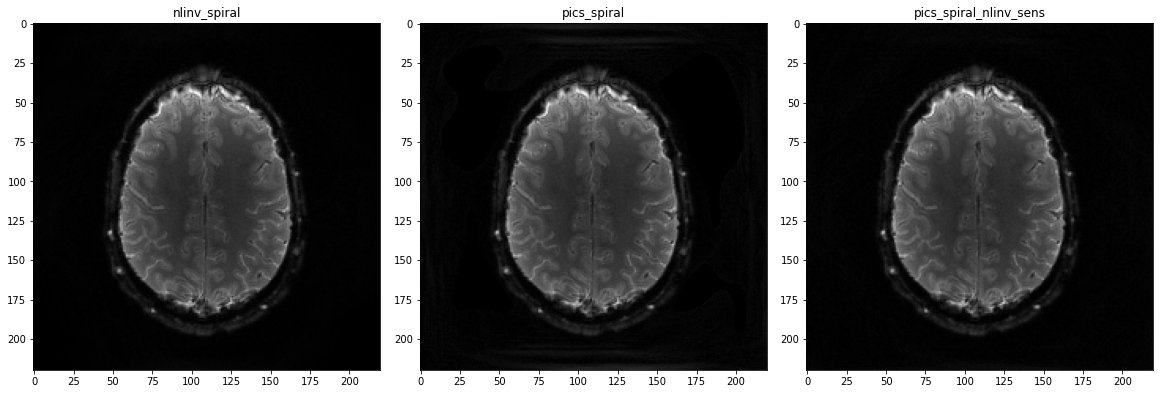

In [51]:
!bart pics -g --gpu-gridding -r1e-4 -t spiral_ETH_cfl/trj_spiral \
    spiral_ETH_cfl/raw_spiral nlinv_sens_spiral_resized \
    pics_spiral_nlinv_sens

plot(["nlinv_spiral", "pics_spiral", "pics_spiral_nlinv_sens"])

### 3.3 Fast coil profiles from low-resolution images

Instead of gridding the entire non-Cartesian data onto a Cartesian grid (by inverse `nufft` followed by `fft`), we can grid a low-resolution part of that data.

As we know that coil profiles can be calculated from a calibration region close to the k-space center, this might yield high-quality coil profiles in much less time.

Let's try it using `bart nufft`, `fft`, and `ecalib`:

Done.


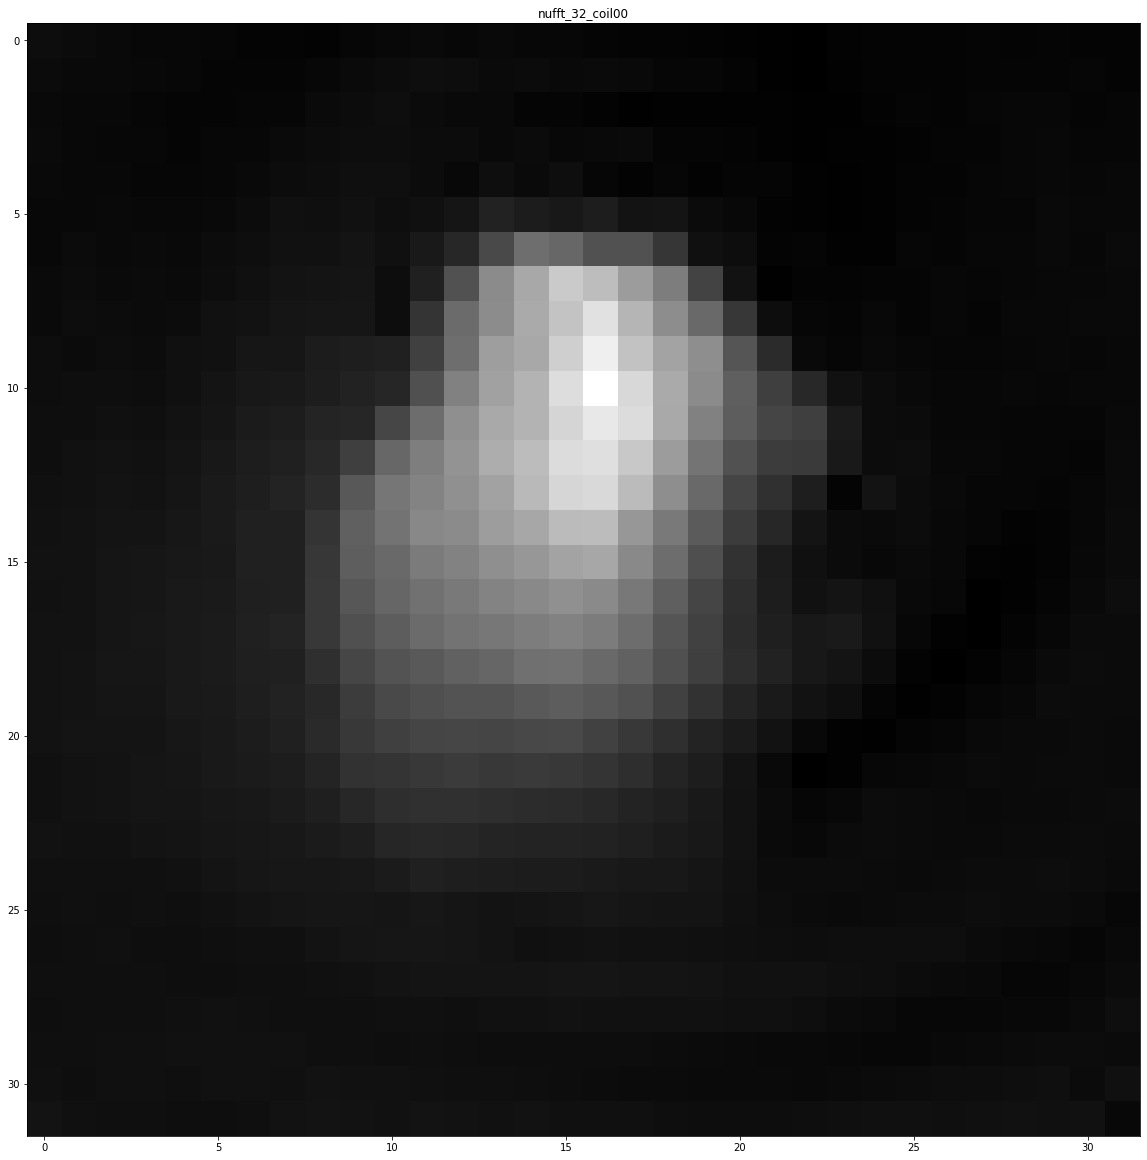

Type: complex float
Dimensions: 16
AoD:	32	32	1	16	1	1	1	1	1	1	1	1	1	1	1	1


In [ ]:
!bart nufft -i -g -d32:32:1 spiral_ETH_cfl/trj_spiral spiral_ETH_cfl/raw_spiral nufft_32

!bart slice 3 0 nufft_32 nufft_32_coil00
plot(["nufft_32_coil00"])
!rm nufft_32_coil00.{cfl,hdr}


!bart fft -u 7 nufft_32 ksp_32
!bart show -m ksp_32


We can almost tell that this is a brain in this image! So next, we will apply ESPIRiT and take a look at the coil profiles.

Done.


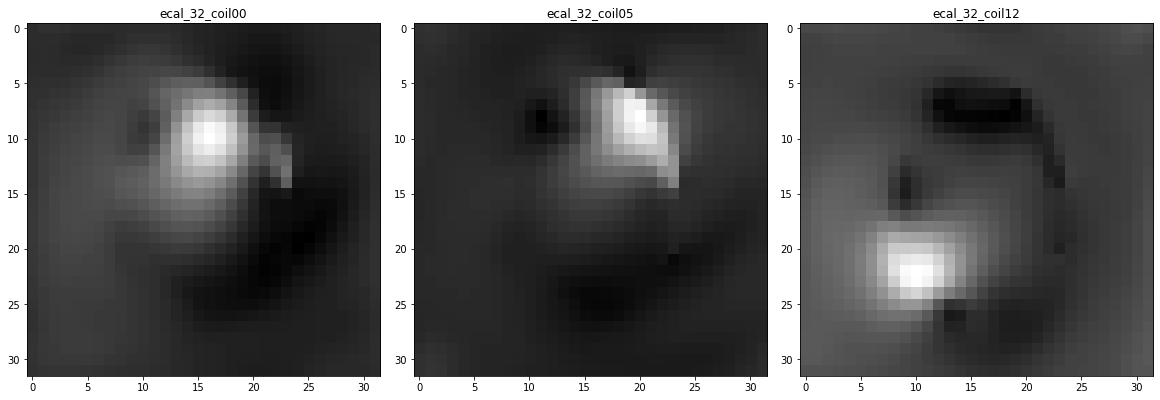

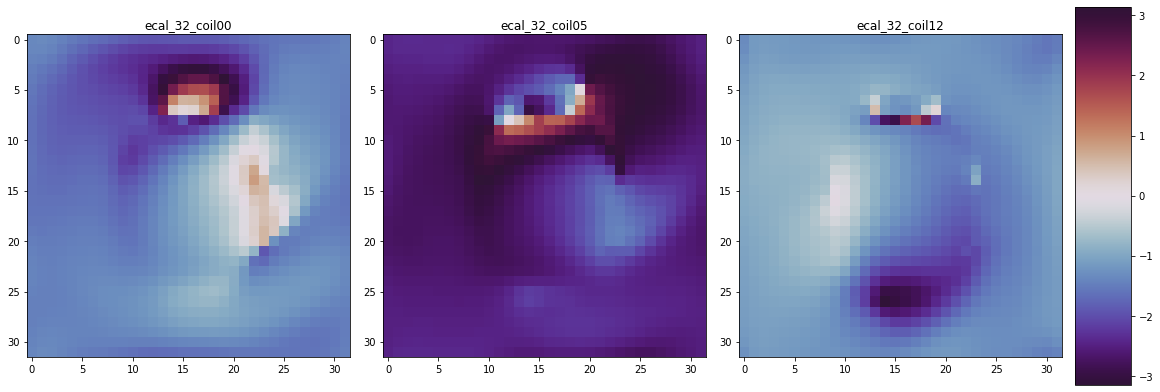

In [53]:
!bart ecalib -m 1 -S ksp_32 ecal_32

!bart slice 3 0 ecal_32 ecal_32_coil00
!bart slice 3 5 ecal_32 ecal_32_coil05
!bart slice 3 12 ecal_32 ecal_32_coil12

plot(["ecal_32_coil00", "ecal_32_coil05", "ecal_32_coil12"])
plot_phase(["ecal_32_coil00", "ecal_32_coil05", "ecal_32_coil12"])

But we cannot use these small coil profiles, because `pics` uses the size of coil profiles as the size of reconstructed images. There, we need to resize them to proper size of 220x220, and the easiest way of doing that is by zero-padding in k-space (that means: transform into k-space, zero pad to desired size, transform back to image space):

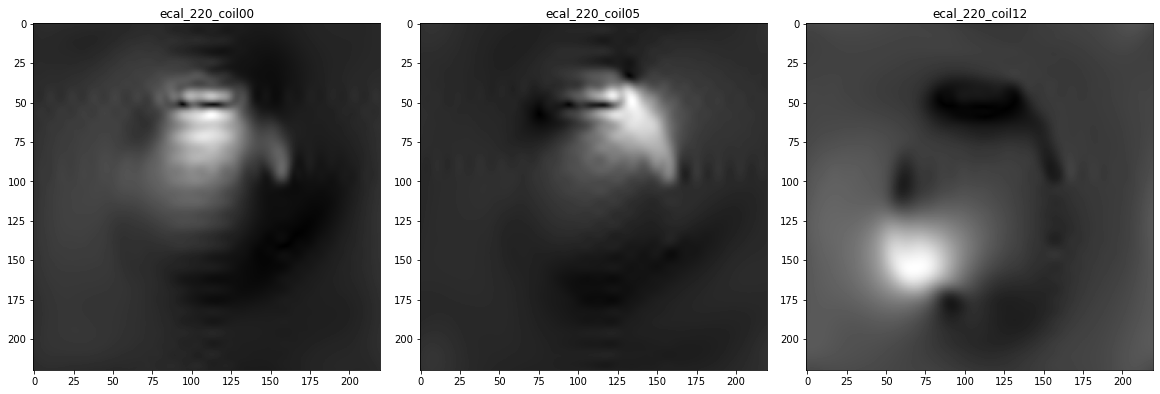

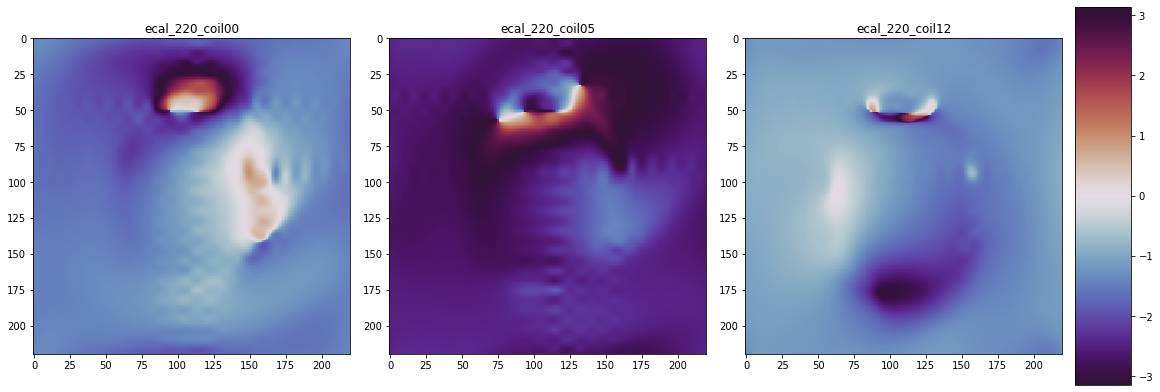

In [54]:
!bart fft -u 7 ecal_32 tmp_ecal_32_fft
!bart resize -c 0 220 1 220 tmp_ecal_32_fft tmp_ecal_220_fft
!bart fft -u -i 7 tmp_ecal_220_fft ecal_220

!bart slice 3 0 ecal_220 ecal_220_coil00
!bart slice 3 5 ecal_220 ecal_220_coil05
!bart slice 3 12 ecal_220 ecal_220_coil12

plot(["ecal_220_coil00", "ecal_220_coil05", "ecal_220_coil12"])
plot_phase(["ecal_220_coil00", "ecal_220_coil05", "ecal_220_coil12"])

We can already see that problems might occur at certain places. Why? ESPIRiT coil profiles are not smooth, they can contain phase poles. Interpolating to a higher resolution then leads to the artifacts seen above. But let's try a reconstruction anyway:

GPU reconstruction
[  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
[220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [220 220   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
Scaling: 2712.390137  (max = 3369.533691/p90 = 2712.390137/median = 1202.961182)
Inverse scaling of the data: 2712.390137
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
lsqr: add GPU wrapper
	 cg:  30
Total Time: 1.674800


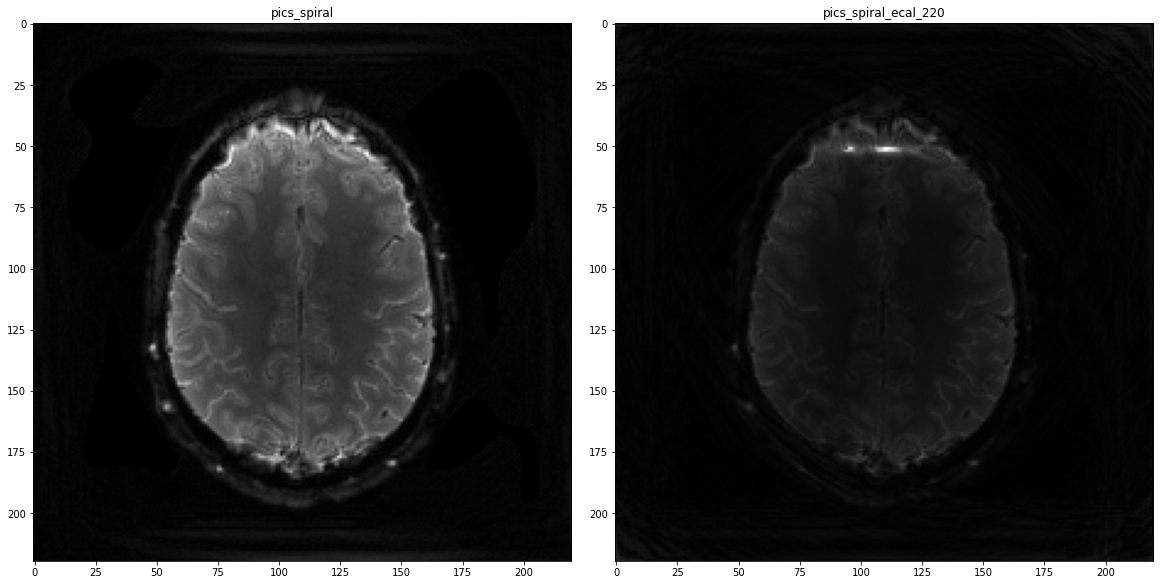

In [55]:
!bart pics -d4 -i30 -g --gpu-gridding -r1e-4 -t spiral_ETH_cfl/trj_spiral \
    spiral_ETH_cfl/raw_spiral ecal_220 \
    pics_spiral_ecal_220

!bart fmac ecal_220 pics_spiral_ecal_220 tmp_CI
!bart rss 8 tmp_CI pics_spiral_ecal_220_rss

plot(["pics_spiral", "pics_spiral_ecal_220"])

With the same options as above, we can see that we have bright spots in the top, just where the artifacts are in the coil profiles.

So is there a better way of calculating low-res coil senstivity profiles? 
Well, we can try `nlinv`. Here, the coil profiles are smoothed by a regularization term. For such small sizes, however, we need to adapt the parameters `a` and `b` a bit, which are the parameters of the coil smoothness regularization:

In [56]:
!bart nlinv -a 32 -b 16  -S -d4 -i11 -g -x 32:32:1 -t spiral_ETH_cfl/trj_spiral \
        spiral_ETH_cfl/raw_spiral \
        rtnlinv_32 rtnlinv_sens_32



[ 32  32   1 ]
nufft kernel dims: [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 81363 (vs. 85459) + 4096
ksp : [  1 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 64  64   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 27121   3   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.000028
Step: 0, Res: 100.000000
	 cg:   2
Step: 1, Res: 94.963973
	 cg:   2
Step: 2, Res: 74.799840
	 cg:   3
Step: 3, Res: 63.411679
	 cg:   3
Step: 4, Res: 48.272390
	 cg:   7
Step: 5, Res: 29.891498
	 cg

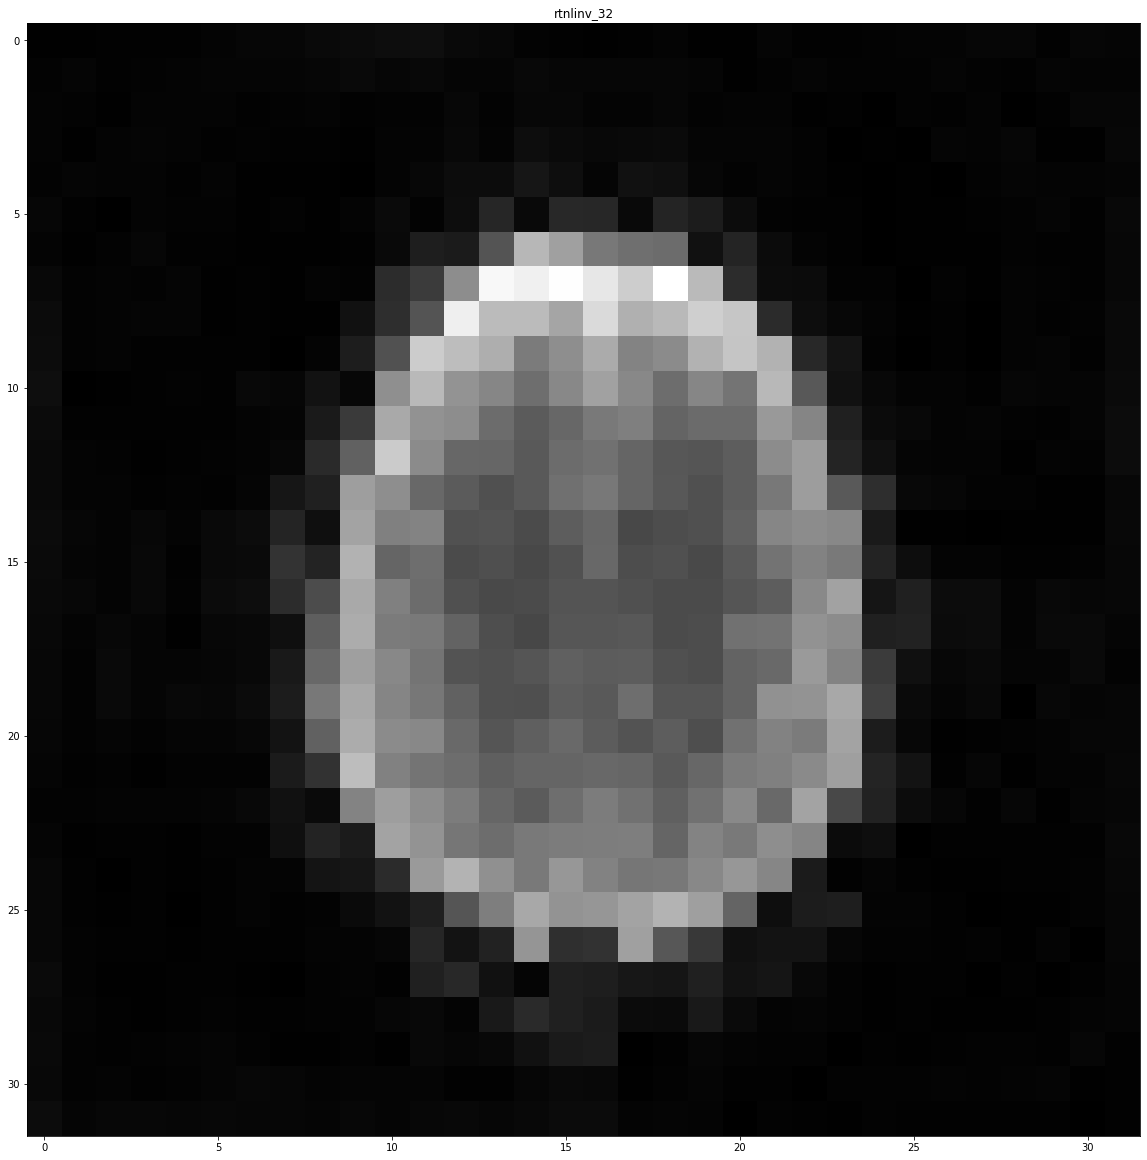

In [57]:
plot(["rtnlinv_32"])

And let's take a look the calculated coil profiles:

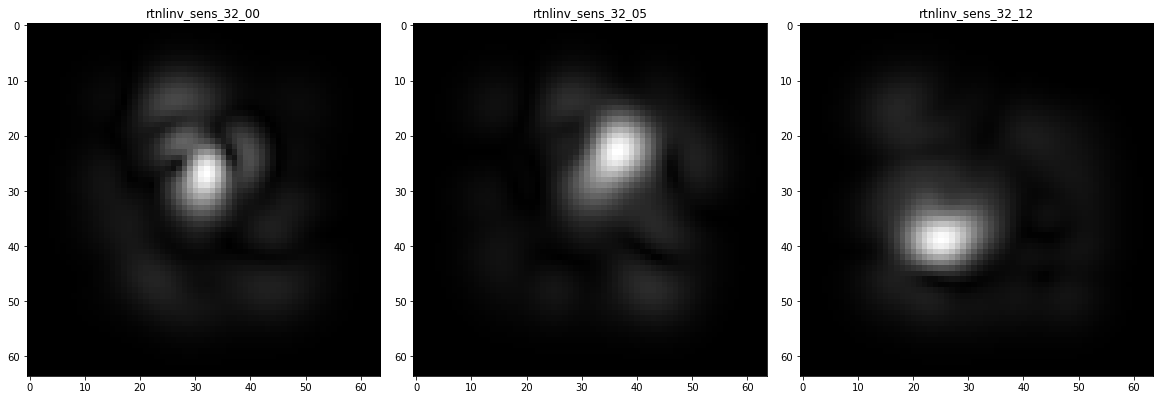

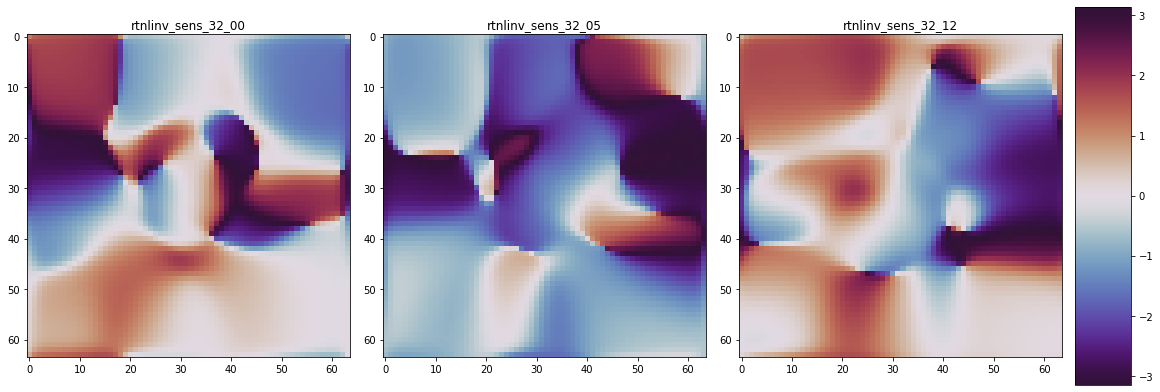

In [58]:
!bart slice 3  0 rtnlinv_sens_32 rtnlinv_sens_32_00
!bart slice 3  5 rtnlinv_sens_32 rtnlinv_sens_32_05
!bart slice 3 12 rtnlinv_sens_32 rtnlinv_sens_32_12


plot(["rtnlinv_sens_32_00", "rtnlinv_sens_32_05", "rtnlinv_sens_32_12"])
plot_phase(["rtnlinv_sens_32_00", "rtnlinv_sens_32_05", "rtnlinv_sens_32_12"])

!rm rtnlinv_sens_32_{00,05,12}.{cfl,hdr}

As `nlinv` calculates on an oversampled grid, these are 64x64 and not 32x32 as the EPSIRiT profiles. But they are also too small to use in `pics` directly. So we do the same steps as above, resizing them by zero-padding in k-space. But do note that we resize them to 440x440 in k-space and then extract the inner 220x220 pixels, as only these correspond to the coil profiles needed by ESPIRiT:

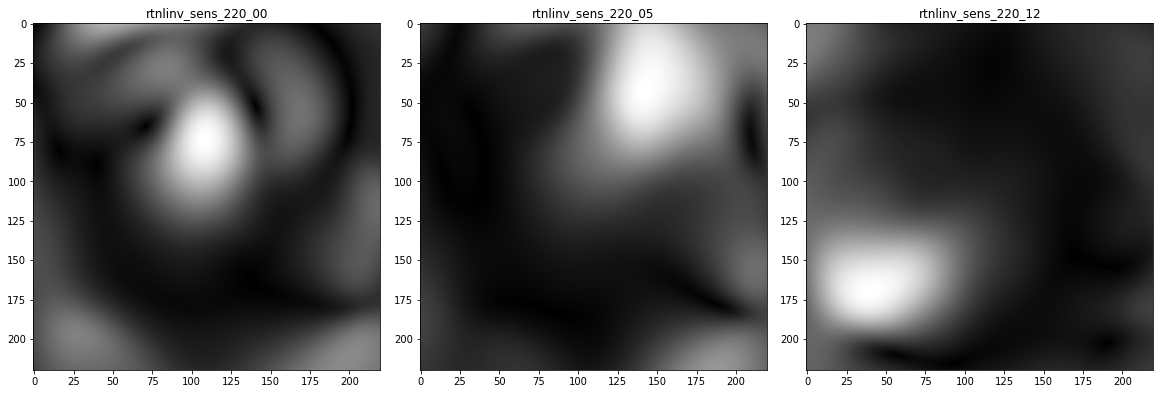

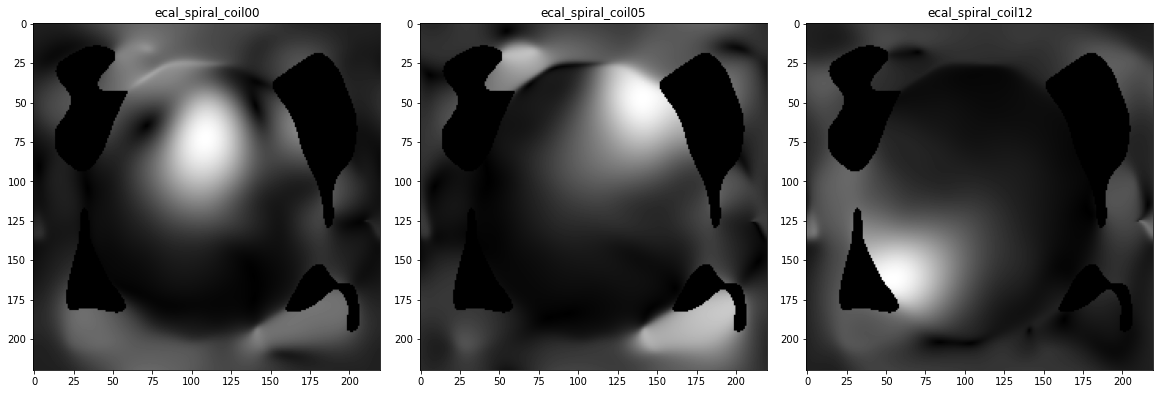

In [60]:
!bart fft -u 7 rtnlinv_sens_32 tmp_fft_rtnlinv_sens_32
!bart resize -c 0 440 1 440 tmp_fft_rtnlinv_sens_32 tmp_fft_rtnlinv_sens_440
!bart fft -u -i 7 tmp_fft_rtnlinv_sens_440 rtnlinv_sens_440
!bart resize -c 0 220 1 220 rtnlinv_sens_440 rtnlinv_sens_220_not_normal
!bart normalize 8 rtnlinv_sens_220_not_normal rtnlinv_sens_220

!bart slice 3  0 rtnlinv_sens_220 rtnlinv_sens_220_00
!bart slice 3  5 rtnlinv_sens_220 rtnlinv_sens_220_05
!bart slice 3 12 rtnlinv_sens_220 rtnlinv_sens_220_12


plot(["rtnlinv_sens_220_00", "rtnlinv_sens_220_05", "rtnlinv_sens_220_12"])
plot(["ecal_spiral_coil00", "ecal_spiral_coil05", "ecal_spiral_coil12"])

!rm rtnlinv_sens_220_{00,05,12}.{cfl,hdr}
!rm tmp_*.{cfl,hdr}

These do look like similar sensitivity profiles, at least where the brain is going to be.

GPU reconstruction
[  1 27121   3  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
[220 220   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.850232


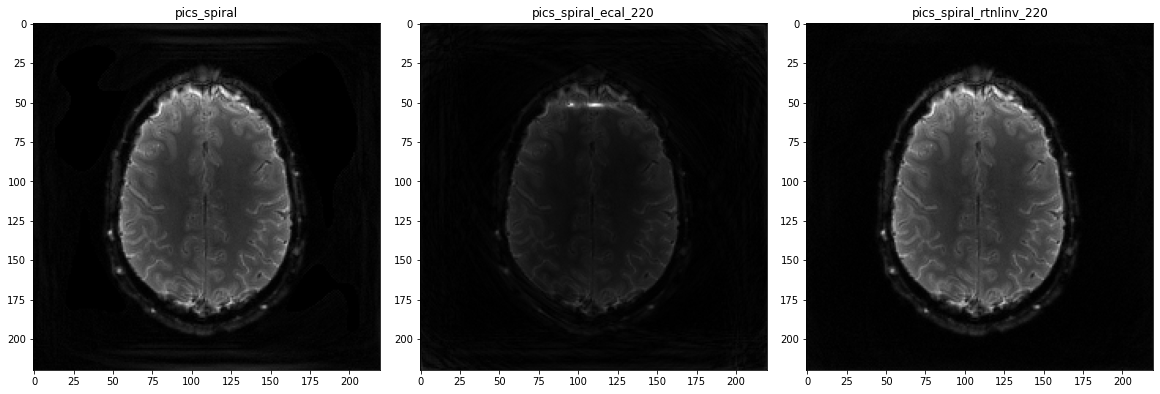

In [61]:
!bart pics -i30 -r1e-4 -S -g --gpu-gridding \
    -t spiral_ETH_cfl/trj_spiral \
    spiral_ETH_cfl/raw_spiral \
    rtnlinv_sens_220 \
    pics_spiral_rtnlinv_220


plot(["pics_spiral", "pics_spiral_ecal_220", "pics_spiral_rtnlinv_220"])

And indeed, a pics reconstruction with these coil profiles leads to a good image (far right).

## 4. Performance and Memory Optimizations

Especially in 3D, non-Cartesian reconstructions become quite memory demanding. For example, coils and coil images of dimensions $256 \times 256 \times 256 \times N_C$ with $N_C=8$ take up 1GB of memory. Considering an oversampling factor of two for the nuFFT, the oversampled coil-images require multiple times 8GB of memory resulting in a peak-memory of about 24GB. In this section, we present low-memory modes of PICS which significantly reduce the peak-memory requirement to the price of partly less efficient parallelization. However, we start with a general performance remark on FFTs on the CPU (FFTW).

### 4.1 FFTW Wisdom

Plans created with the FFTW_MEASURE, FFTW_PATIENT, or FFTW_EXHAUSTIVE options produce near-optimal FFT performance, but may require a long time to compute because FFTW must measure the runtime of many possible plans and select the best one. This setup is designed for the situations where so many transforms of the same size must be computed that the start-up time is irrelevant. For short initialization times, but slower transforms, we have provided FFTW_ESTIMATE. The wisdom mechanism is a way to get the best of both worlds: you compute a good plan once, save it to disk, and later reload it as many times as necessary. The wisdom mechanism can actually save and reload many plans at once, not just one.

*https://www.fftw.org/fftw3_doc/Words-of-Wisdom_002dSaving-Plans.html*

By default, BART uses FFTW_ESTIMATE to create FFT plans, however, FFTW_MEASURE is used if BART is run with the environment variable **BART_USE_FFTW_WISDOM=1**. If BART is run with the TOOLBOX_PATH environment set, the wisdom is stored at or loaded from the TOOLBOX_PATH.

**WARNING:** BART_USE_FFTW_WISDOM=1 let's FFTW find an optimal algorithm, however, this is not deterministic (depending on the work load of the system). Hence, reconstructions might become not bitwise reproducible (which is currently only the case for single threaded gridding).

In the following, we show how to use FFTW_WISDOM, however, the performance gain largely depends on the system.

In [62]:
%%bash

rm -f $TOOLBOX_PATH/save/fftw/*.fftw
ls $TOOLBOX_PATH/save/fftw


README.txt


In [66]:
%%bash

bart traj -o2 -r trj
bart phantom -s4 -ttrj -k ksp
bart phantom -S4 col

export DEBUG_LEVEL=-1
export OMP_NUM_THREADS=4
export BART_USE_FFTW_WISDOM=0

/usr/bin/time -f "No Wisdom: CPU Time: %e; CPU Memory (KB): %M"		bart pics -i30 -t trj ksp col rec1

export BART_USE_FFTW_WISDOM=1
/usr/bin/time -f "Creating Wisdom: CPU Time: %e; CPU Memory (KB): %M"	bart pics -i30 -t trj ksp col rec2
/usr/bin/time -f "Using Wisdom: CPU Time: %e; CPU Memory (KB): %M"	bart pics -i30 -t trj ksp col rec3

ls -lah $TOOLBOX_PATH/save/fftw

total 40K
drwxr-xr-x 2 root root 4.0K Dec  1 14:49 .
drwxr-xr-x 4 root root 4.0K Dec  1 14:36 ..
-rw-r--r-- 1 root root 2.6K Dec  1 14:49 N_16_BACKWARD_0_FLAGS_3_DIMS_128_128_1_1_1_1_1_1_1_1_1_1_1_1_1_1.fftw
-rw-r--r-- 1 root root 2.2K Dec  1 14:49 N_17_BACKWARD_0_FLAGS_3_DIMS_128_128_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1.fftw
-rw-r--r-- 1 root root  949 Dec  1 14:49 N_17_BACKWARD_0_FLAGS_3_DIMS_128_128_1_4_1_1_1_1_1_1_1_1_1_1_1_1_4.fftw
-rw-r--r-- 1 root root 2.6K Dec  1 14:49 N_17_BACKWARD_1_FLAGS_3_DIMS_128_128_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1.fftw
-rw-r--r-- 1 root root 1.5K Dec  1 14:49 N_17_BACKWARD_1_FLAGS_3_DIMS_128_128_1_4_1_1_1_1_1_1_1_1_1_1_1_1_4.fftw
-rw-r--r-- 1 root root 1.6K Dec  1 14:49 N_18_BACKWARD_0_FLAGS_3_DIMS_128_128_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_4.fftw
-rw-r--r-- 1 root root 1.7K Dec  1 14:49 N_18_BACKWARD_1_FLAGS_3_DIMS_128_128_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_4.fftw
-rw-r--r-- 1 root root   18 Dec  1 14:36 README.txt


No Wisdom: CPU Time: 0.94; CPU Memory (KB): 46676
Creating Wisdom: CPU Time: 1.41; CPU Memory (KB): 47600
Using Wisdom: CPU Time: 1.63; CPU Memory (KB): 46844


### 4.2 Low-Memory Modes (Important for 3D)

The recent BART updates integrate new low memory modes for the nuFFT and PICS.
The different versions of the SENSE normal operator and the memory buffers required are visualized in this Figure.

* **A**: Normal mode of nuFFT where the FOV needs to be overgridded by a factor o: o=2 in BART but stay tuned.
* **B**: Even and odd phases of the oversampled grid are processed sequentially (**--lowmem** option)
* **C**: Similar but using Toeplitz trick (**--lowmem** option)

Moreover, the normal operator can be computed sequentially for different coils to reduce the peak memory: **--lowmem-stack=8**

![title](https://github.com/mrirecon/bart-webinars/blob/webinar_07/webinar7/figures/mem.png?raw=1)

In [ ]:
%%bash

bart traj -x64 -3 -o2 -r trj
bart phantom -3 -s8 -ttrj -k ksp
bart phantom -3 -x64 -S8 col

export DEBUG_LEVEL=-1
export OMP_NUM_THREADS=$(nproc)

/usr/bin/time -f "Normal: CPU Time: %e; CPU Memory (KB): %M"		bart pics -i30 -t trj ksp col rec1
/usr/bin/time -f "Lowmem: CPU Time: %e; CPU Memory (KB): %M"		bart pics --lowmem -i30 -t trj ksp col rec1
/usr/bin/time -f "Coil-Stack: CPU Time: %e; CPU Memory (KB): %M"	bart pics --lowmem-stack=8 -i30 -t trj ksp col rec1
/usr/bin/time -f "No-Toeplitz: CPU Time: %e; CPU Memory (KB): %M"	bart pics --lowmem-stack=8 --no-toeplitz -i30 -t trj ksp col rec1

### 4.3 Results on our Local Server
Dimensionality: $256 \times 256 \times 256 \times N_C$ with $N_C=8$

CPU Reconstruction:

![title](https://github.com/mrirecon/bart-webinars/blob/webinar_07/webinar7/figures/bench_cpu.png?raw=1)

GPU Reconstruction:

![title](https://github.com/mrirecon/bart-webinars/blob/webinar_07/webinar7/figures/bench_gpu.png?raw=1)

## 5 Exercise

As a small exercise combining the tools shown above, we provide multi coil k-space data and the trajectory of a phantom in the directory **ex**. The native matrix size is $256x256$, but maybe you are more efficient in reconstruction:)

In [68]:
%%bash

bart show -m ex/ksp
bart show -m ex/trj
bart nlinv -g -t ex/trj ex/ksp ex/nlinv

Type: complex float
Dimensions: 16
AoD:	1	512	256	8	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	3	512	256	1	1	1	1	1	1	1	1	1	1	1	1	1
[  0   0   0 ]
Scaling: 0.000010


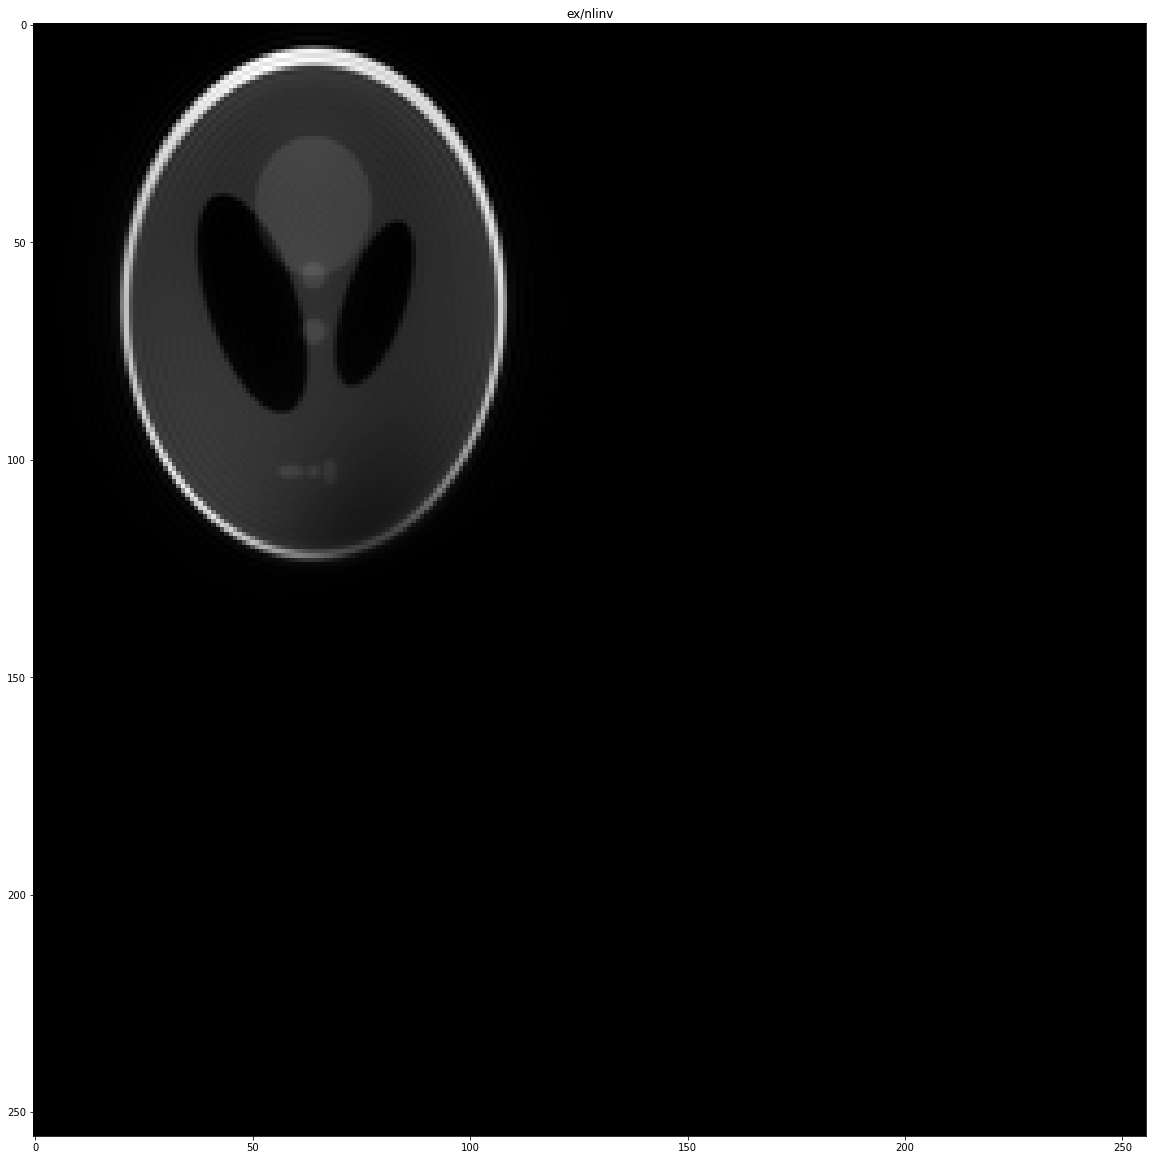

In [69]:
plot(["ex/nlinv"])

#### Intentionally hidden



In [70]:
%%bash
# generation of exercise:
exit 0
mkdir -p ex
cd ex


bart traj -x128 -y256 -r -o4 trj_os_tmp
bart phantom -s8 -k -t trj_os_tmp ksp_os

bart traj -x256 -y256 -r -o2 trj
bart fovshift -t trj -s0.25:0.25:0 ksp_os ksp


bart nlinv -t trj ksp img col


Process is interrupted.
